In [58]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from typing import TYPE_CHECKING, Any, Callable, Optional, Union
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, sync_envs_normalization
from stable_baselines3.common.logger import Logger
import gymnasium as gym
from gym.wrappers import RecordVideo
import numpy as np
import os
import matplotlib.pyplot as plt

np.bool8 = np.bool_

In [59]:
#training timesteps
training = 12000
rec_no = 250
video_save_freq = 1000
models_saved = [rec_no * i for i in range(1,int(training/rec_no)+1)]
print(models_saved)
# Setup
save_path = "./checkpoints/"
videos = []
for i in models_saved:
    if i % video_save_freq == 0:
        videos.append(i)
print(videos)


[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]


In [60]:
class SaveOnStepCallback(BaseCallback):
    def __init__(self, save_freq: int, save_path: str, verbose: int = 0):
        super(SaveOnStepCallback, self).__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.num_timesteps}")
            self.model.save(save_file)
        return True

In [ ]:
# Dictionary to track the highest reward for each timestep
highest_reward_per_timestep = {y: -np.inf for y in models_saved}
best_trajectory_per_timestep = {}
best_model_per_timestep = {}
best_env_seed_per_timestep = {}
best_actions = {}
callback = SaveOnStepCallback(save_freq=rec_no, save_path=save_path)

runs = 10
avg_rewards = []
for run in range(0,runs):
    print("Run", run)
    run_list = []
           
    # Load the environment and model
    env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")  # Render for visualization
    
    n_actions = env.action_space.shape[-1]
    
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    model = TD3("MlpPolicy", env, action_noise=action_noise)
    #model.batch_size = int(64)
    #model.learning_rate = 10**(-2.5)
    model = model.learn(training,callback = callback)

    for y in models_saved:
        c_seed=np.random.randint(0, 10000)
        obs, info = env.reset(seed=c_seed)  # Random seed for reproducibility
    
        done = False
        total_episode_reward = 0
        trajectory = []
        actions = []
        checkpoint_path = f"./checkpoints/model_step_{y}.zip"
        loaded_model = TD3.load(checkpoint_path)
        while not done:
            # Predict action using the trained model
            action, _ = loaded_model.predict(obs, deterministic=True)
    
            actions.append(action)
    
            # Take the action in the environment
            obs, reward, done,truncated, info = env.step(action)
            
            # Collect data
            trajectory.append((obs, action, reward))
            total_episode_reward += reward
        print("ran",y)
        actions = np.array(actions)
        run_list.append(total_episode_reward)
        
        # Check if this is the highest reward for the current training timestep
        if total_episode_reward > highest_reward_per_timestep[y]:
            #print(f"New highest reward for {y} timesteps: {total_episode_reward} (previous: {highest_reward_per_timestep[y]})")
            highest_reward_per_timestep[y] = total_episode_reward
            best_trajectory_per_timestep[y] = trajectory  # Save the best trajectory
            best_model_per_timestep[y] = loaded_model  # Save the model for video recording
            best_env_seed_per_timestep[y] = c_seed  # Save the environment seed
            best_actions[y] = actions 
            # Specify the directory and filename
            save_dir = f"./checkpoints/best_models/timesteps_{training}"
            os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            save_path = os.path.join(save_dir, f"{y}_timesteps_best_model.zip")
            
            # Save the model
            model.save(save_path)
            if y == models_saved[-1]:
               print(highest_reward_per_timestep)
                
    env.close()
    avg_rewards.append(run_list)    
    # Specify the directory you want to clean up
    directory = "./checkpoints"
    
    # Iterate through the files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a zip file
        if filename.endswith(".zip"):
            file_path = os.path.join(directory, filename)
            # Remove the file
            os.remove(file_path)
    del model 
    del env
print("done!")



Run 0
ran 250
ran 500
ran 750
ran 1000
ran 1250
ran 1500
ran 1750
ran 2000
ran 2250
ran 2500
ran 2750
ran 3000
ran 3250
ran 3500
ran 3750
ran 4000
ran 4250
ran 4500
ran 4750
ran 5000
ran 5250
ran 5500
ran 5750
ran 6000
ran 6250
ran 6500
ran 6750
ran 7000
ran 7250
ran 7500
ran 7750
ran 8000
ran 8250
ran 8500
ran 8750
ran 9000
ran 9250
ran 9500
ran 9750
ran 10000
ran 10250
ran 10500
ran 10750
ran 11000
ran 11250
ran 11500
ran 11750
ran 12000
{250: 3.0, 500: 3.0, 750: 3.0, 1000: 4.0, 1250: 27.0, 1500: 59.0, 1750: 92.0, 2000: 62.0, 2250: 65.0, 2500: 59.0, 2750: 53.0, 3000: 46.0, 3250: 42.0, 3500: 44.0, 3750: 47.0, 4000: 42.0, 4250: 43.0, 4500: 42.0, 4750: 42.0, 5000: 43.0, 5250: 43.0, 5500: 43.0, 5750: 45.0, 6000: 47.0, 6250: 43.0, 6500: 47.0, 6750: 42.0, 7000: 44.0, 7250: 48.0, 7500: 49.0, 7750: 53.0, 8000: 46.0, 8250: 50.0, 8500: 50.0, 8750: 49.0, 9000: 48.0, 9250: 46.0, 9500: 51.0, 9750: 49.0, 10000: 46.0, 10250: 55.0, 10500: 60.0, 10750: 59.0, 11000: 55.0, 11250: 61.0, 11500: 53.0, 117

In [40]:
# Specify the directory you want to clean up
directory = "./checkpoints"
# Iterate through the files in the directory
for filename in os.listdir(directory):
# Check if the file is a zip file
    if filename.endswith(".zip"):
        file_path = os.path.join(directory, filename)
        # Remove the file
        os.remove(file_path)

C:\Users\Indum\AppData\Local\Temp\ipykernel_18704\2374696539.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))  # Optional: set figure size


Recording video for the best episode with 3000 timesteps (reward: 172.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_3000\eval_best_run-episode-0.mp4
Recording video for the best episode with 6000 timesteps (reward: 134.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_6000\eval_best_run-episode-0.mp4
Recording video for the best episode with 9000 timesteps (reward: 124.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_9000\eval_best_run-episode-0.mp4
Recording video for the best episode with 12000 timesteps (reward: 121.0)
MoviePy - Building video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4.
MoviePy - Writing video C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\Indum\Documents\Year4\Reinforcement_Learning\Lab\Coursework2\stable-baselines3-master\videos\best\timesteps_12000\timesteps_12000\eval_best_run-episode-0.mp4
[[5.0, 5.0, 44.0, 64.0, 129.0, 71.0, 77.0, 61.0, 62.0, 80.0, 73.0, 172.0, 82.0, 78.0, 76.0, 95.0, 81.0, 82.0, 76.0, 86.0, 167.0, 61.0, 60.0, 66.0, 72.0, 65.0, 68.0, 59.0, 61.0, 76.0, 73.0, 63.0, 63.0, 57.0, 61.0, 57.0, 97.0, 57.0, 76.0, 66.0, 59.0, 84.0, 84.0, 56.0, 61.0, 80.0, 64.0, 65.0], [3.0, 3.0, 3.0, 6.0, 40.0, 45.0, 46.0, 42.0, 44.0, 40.0, 41.0, 42.0, 45.0, 47.0, 50.0, 45.0, 45.0, 47.0, 49.0, 48.0, 45.0, 45.0, 46.0, 43.0, 45.0, 46.0, 46.0, 48.0, 45.0, 47.0, 45.0, 47.0, 47.0, 45.0, 49.0, 47.0, 52.0, 50.0, 54.0, 48.0, 49.0, 48.0, 47.0, 51.0, 53.0, 55.0, 52.0, 54.0], [3.0, 3.0, 3.0, 8.0, 47.0, 40.0, 22.0, 43.0, 50.0, 48.0, 53.0, 57.0, 55.0, 55.0, 45.0, 51.0, 47.0, 54.0, 61.0, 49.0, 41.0, 37.0, 37.0, 37.0, 37.0, 38.0, 35.0, 37.0, 36.0, 38.0, 38.0, 38.0, 37.0, 38.0, 55.0, 41.0, 45.

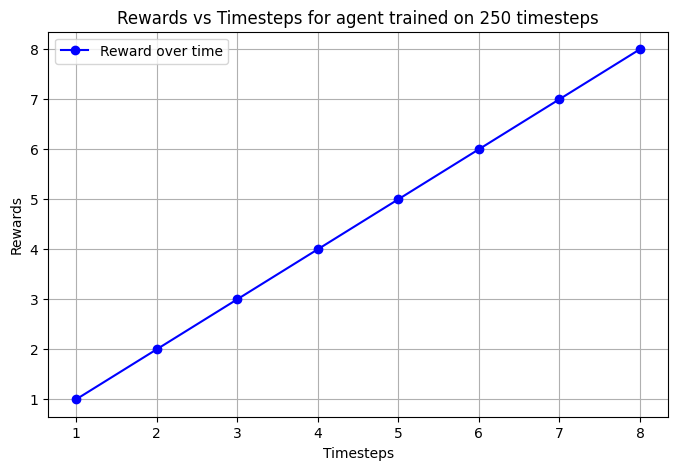

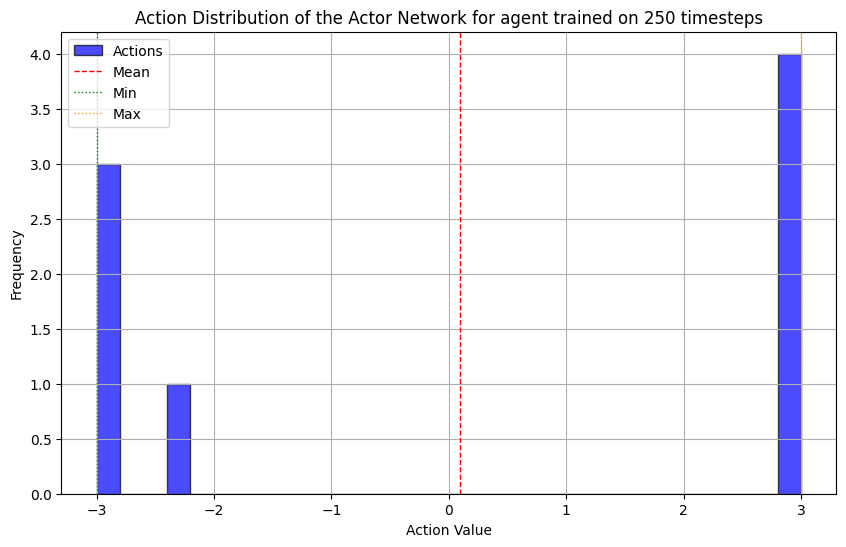

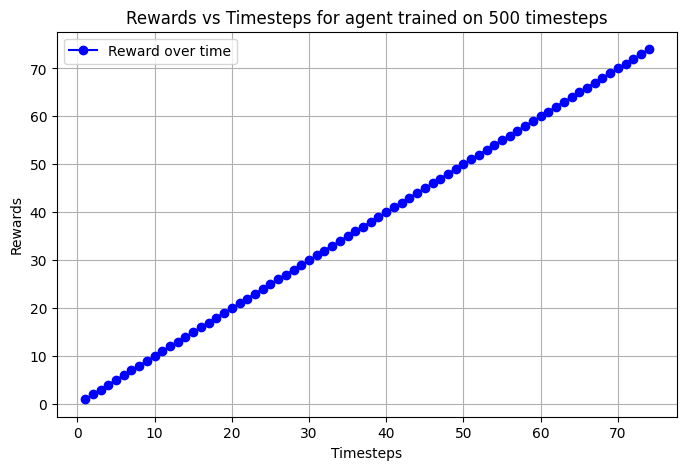

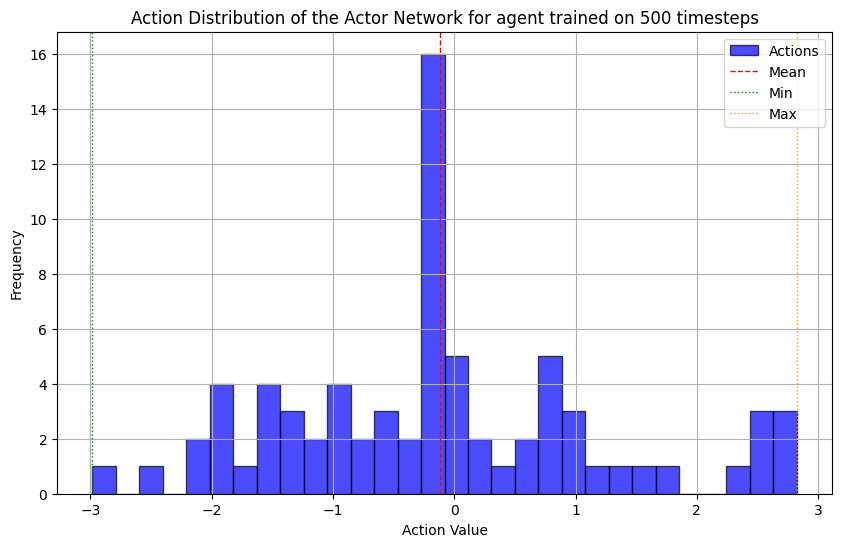

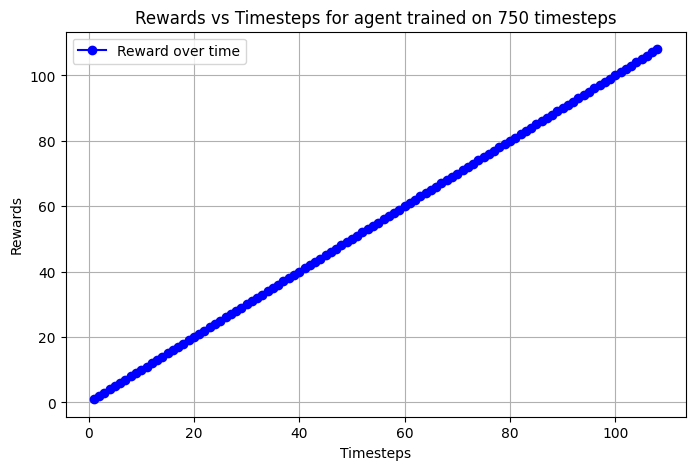

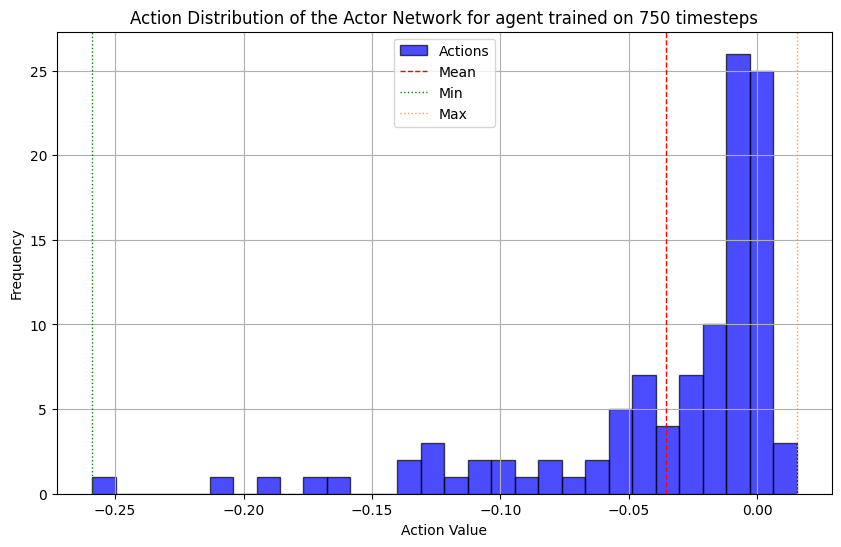

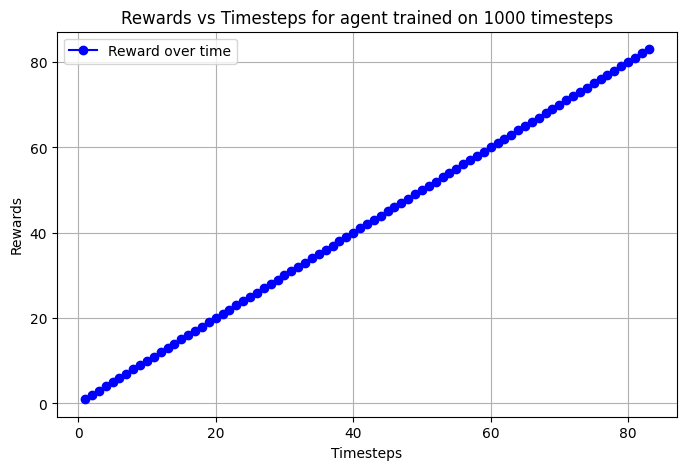

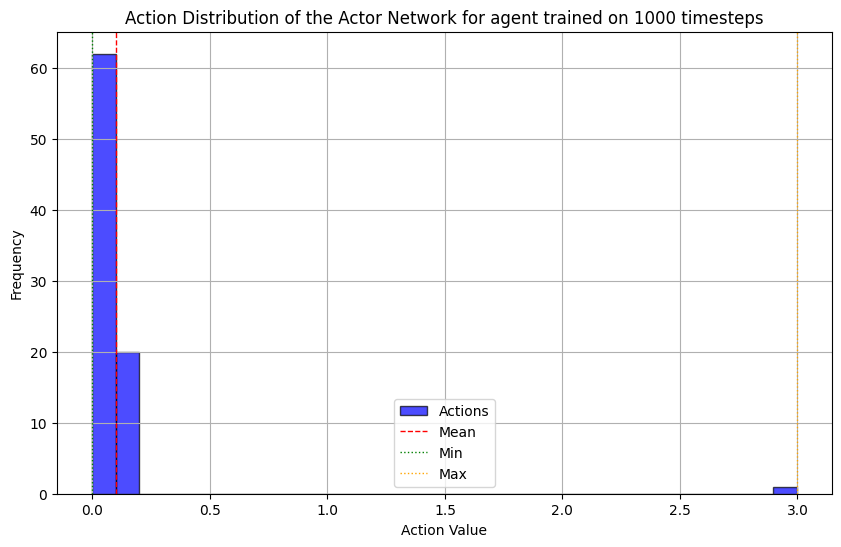

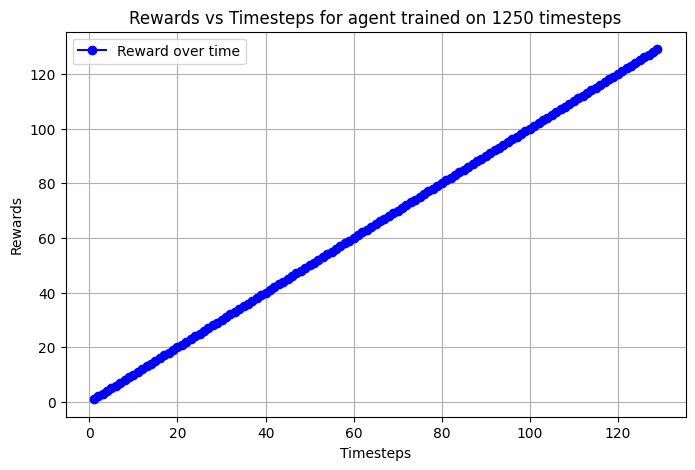

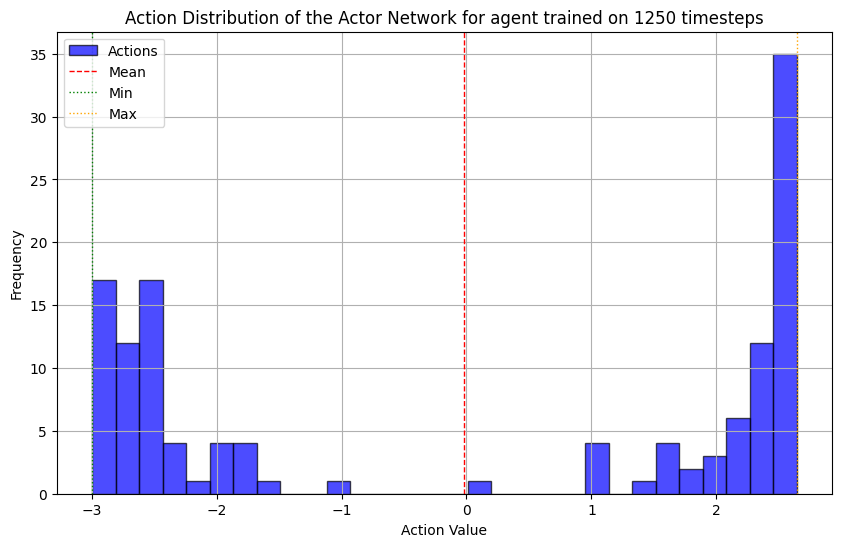

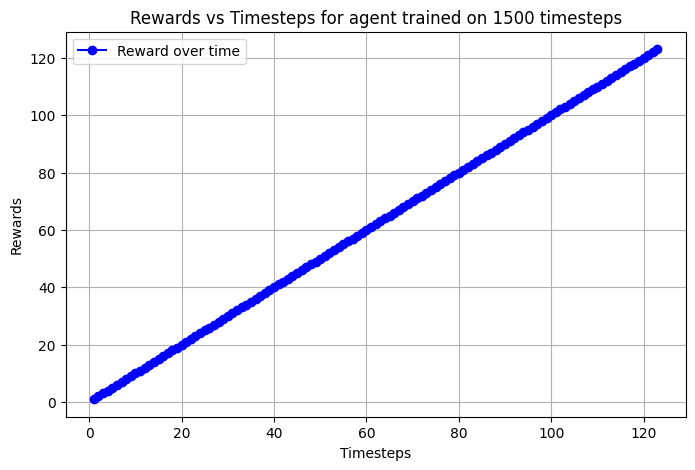

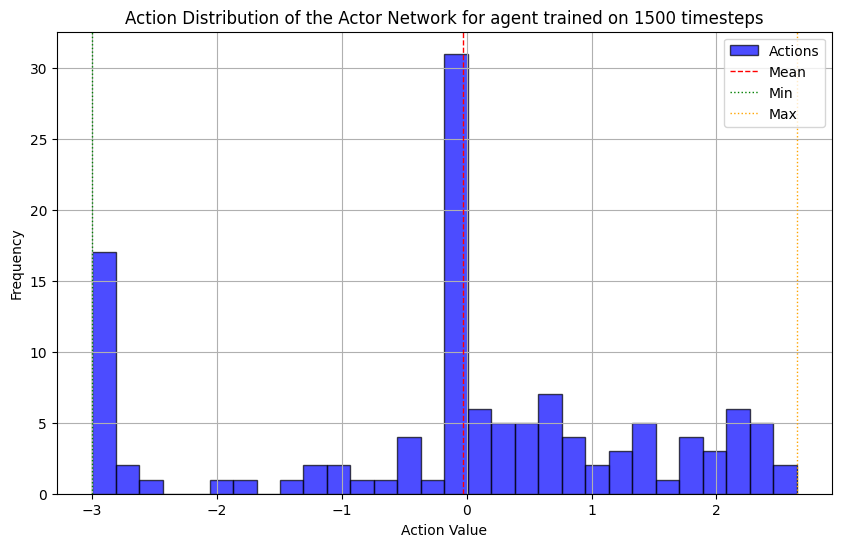

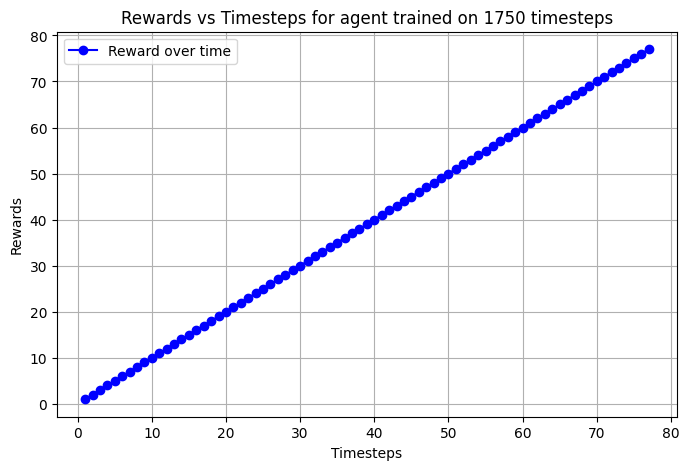

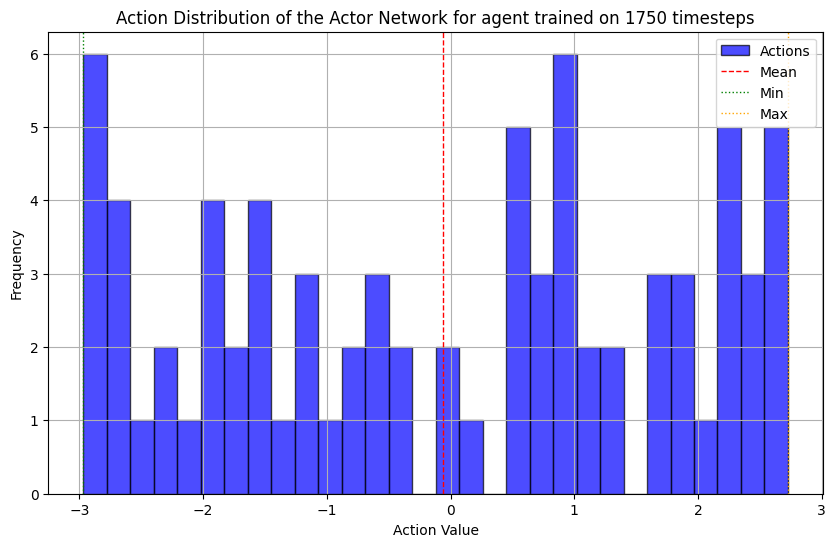

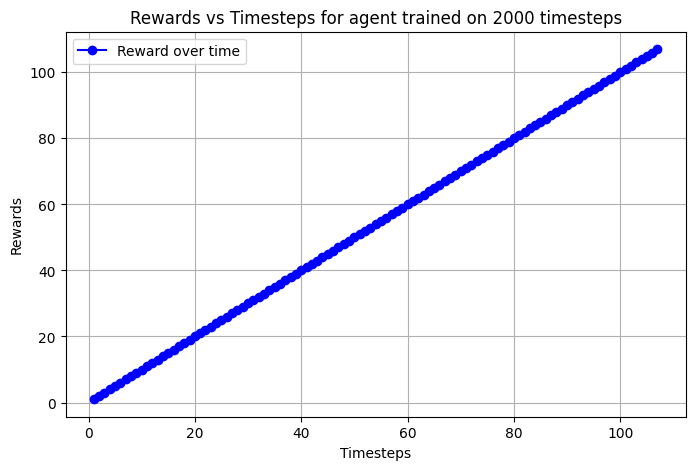

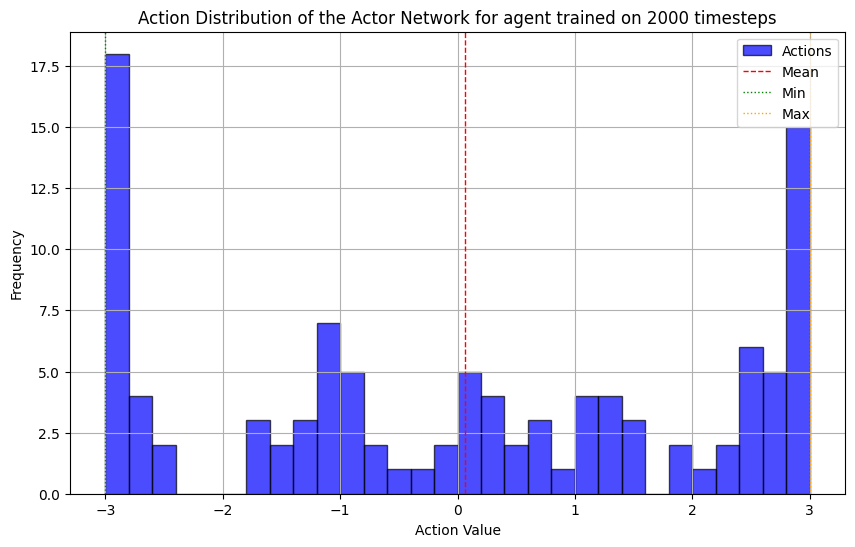

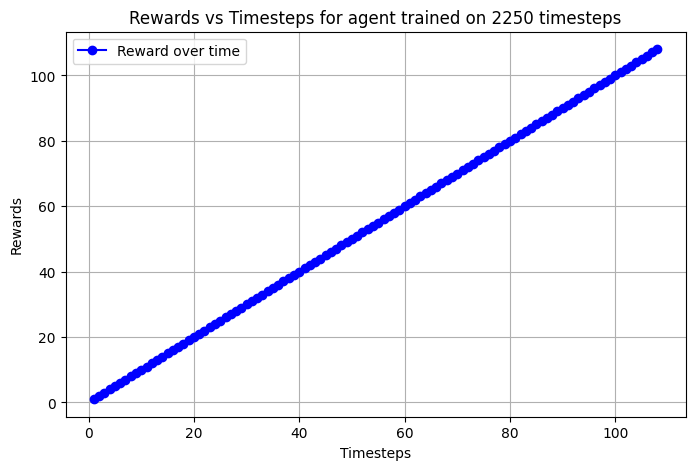

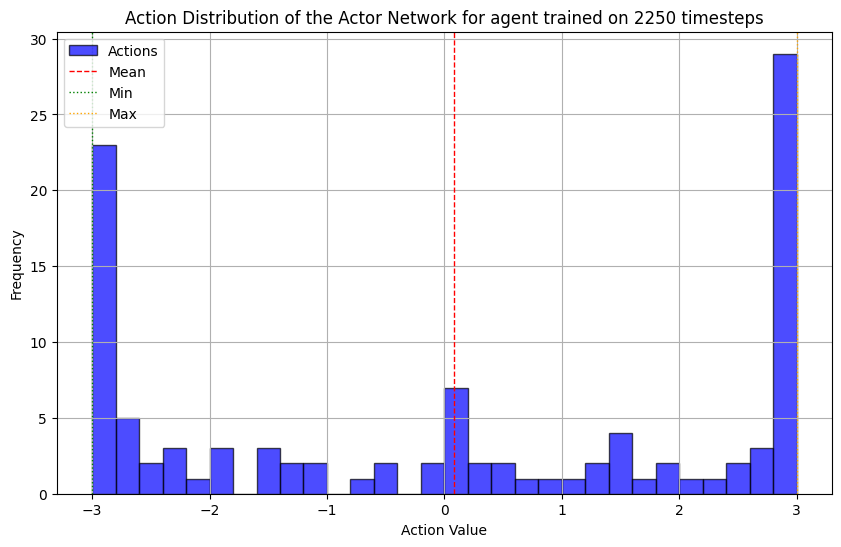

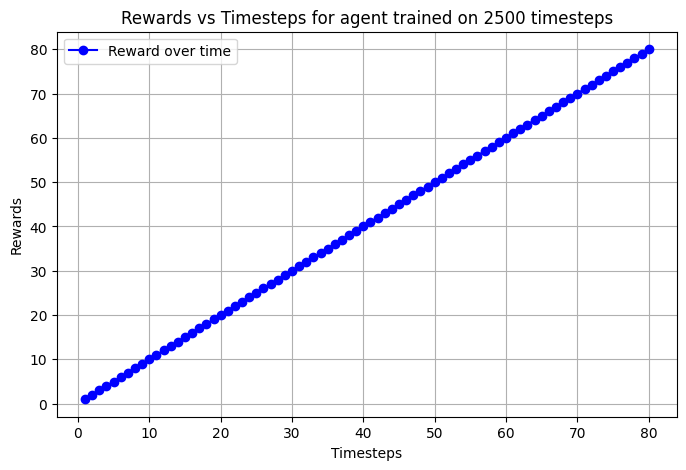

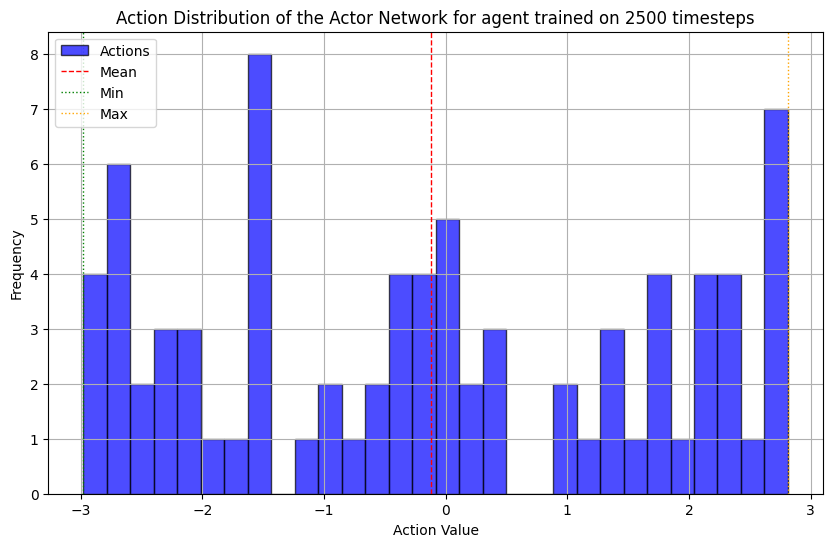

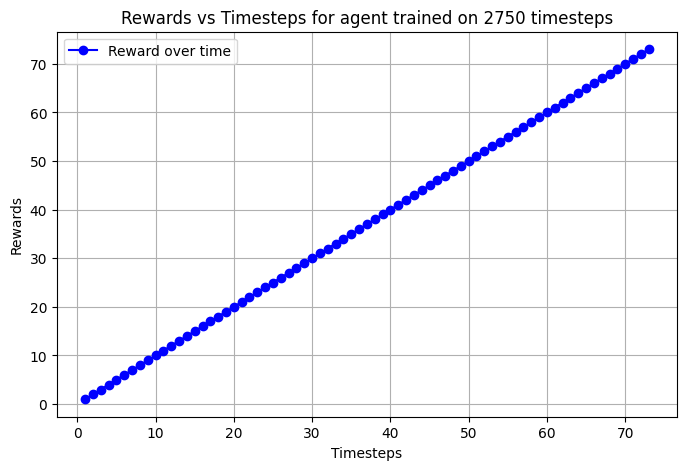

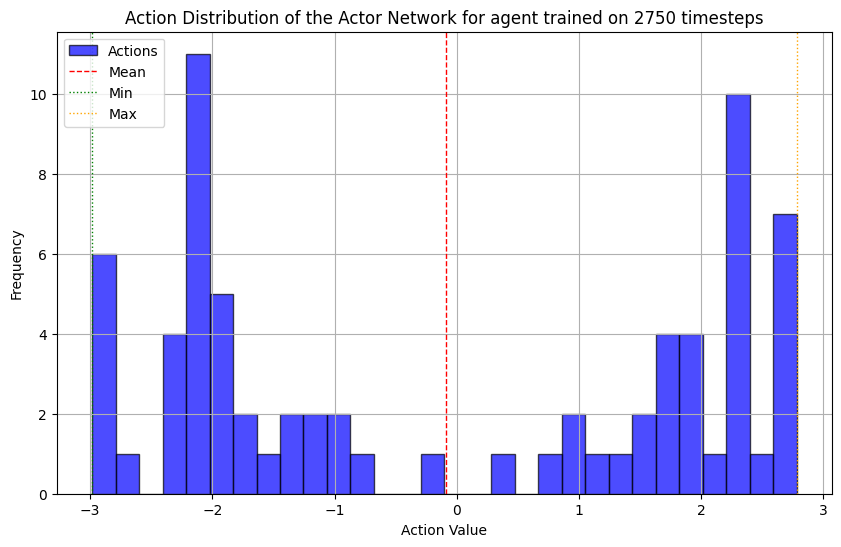

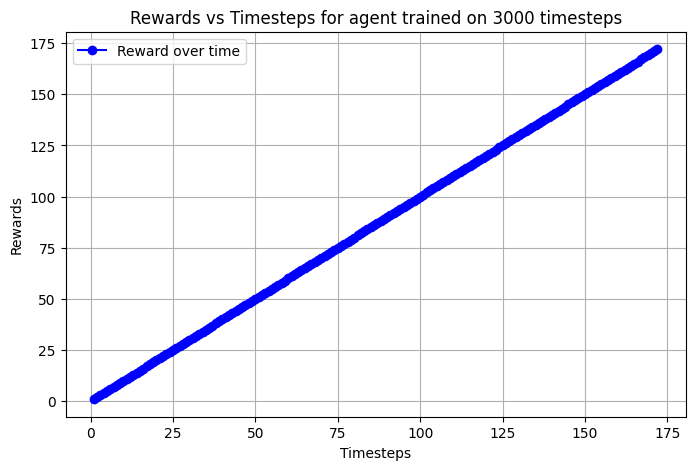

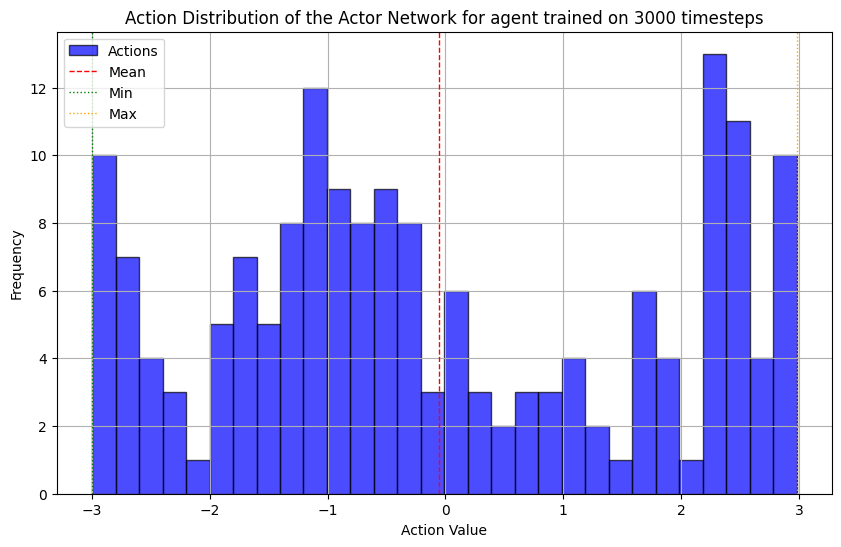

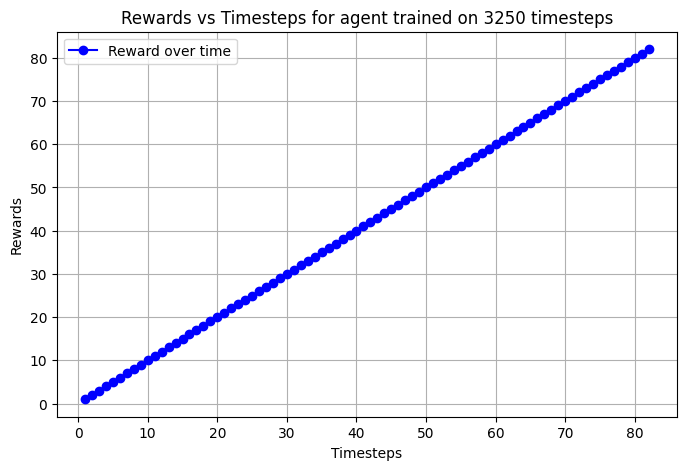

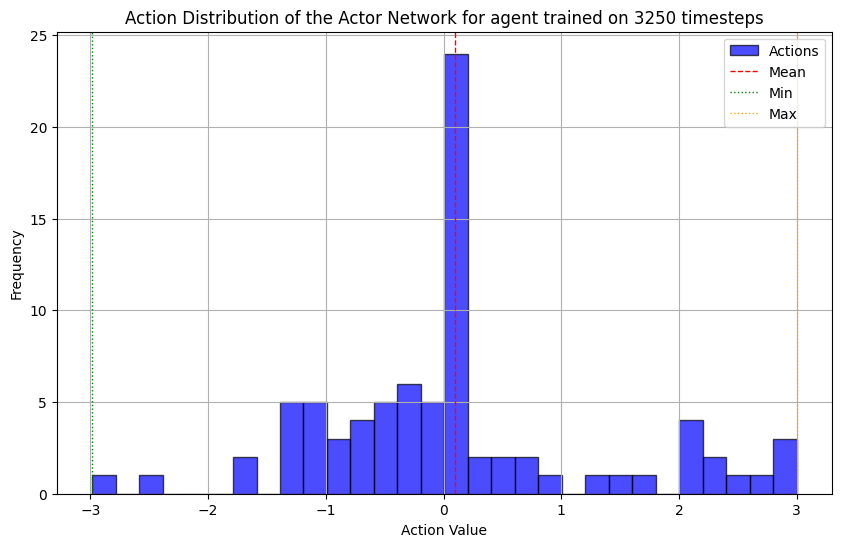

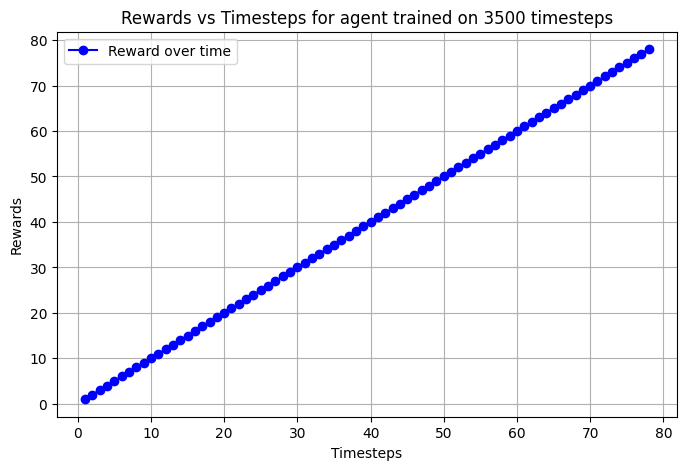

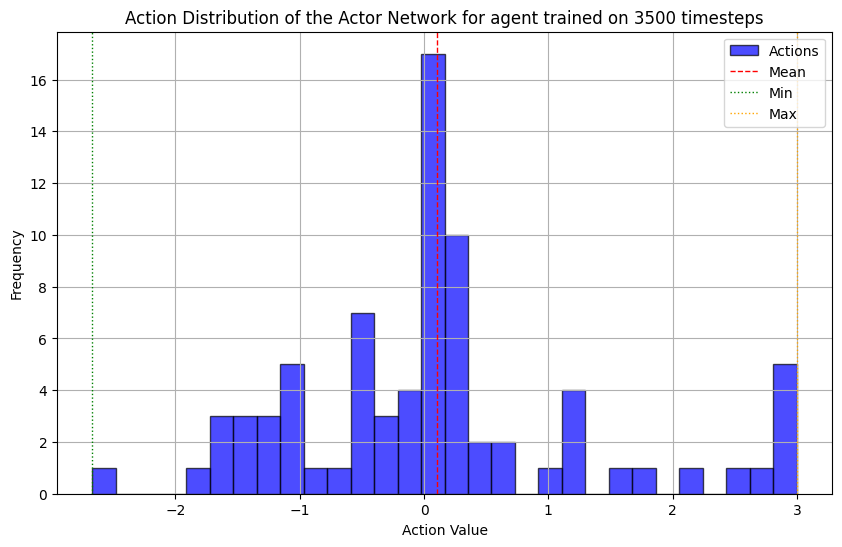

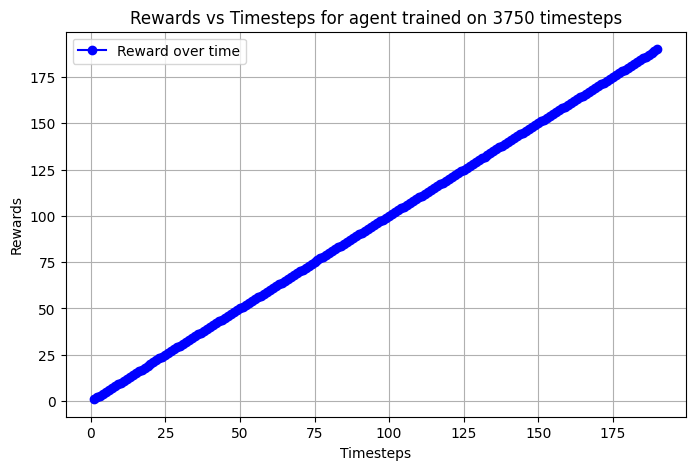

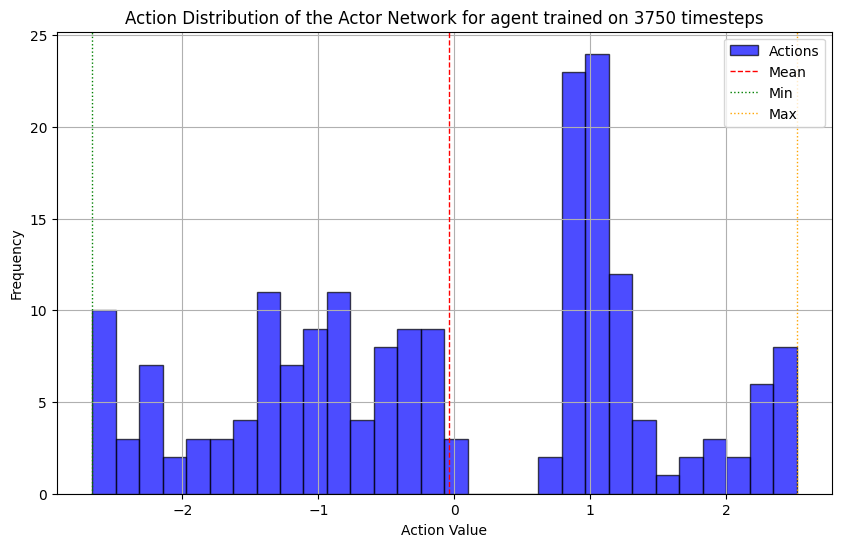

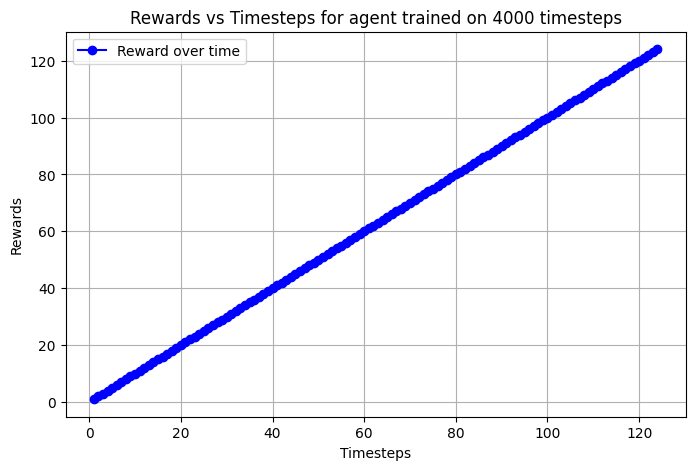

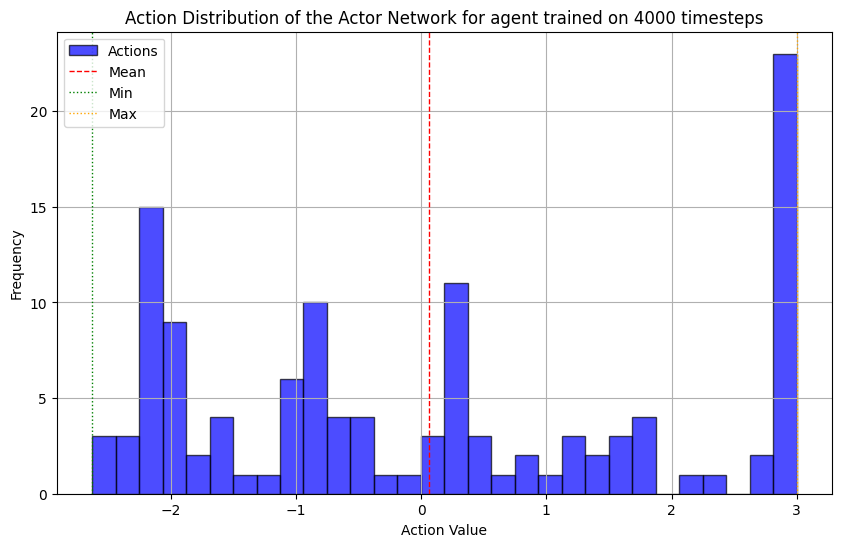

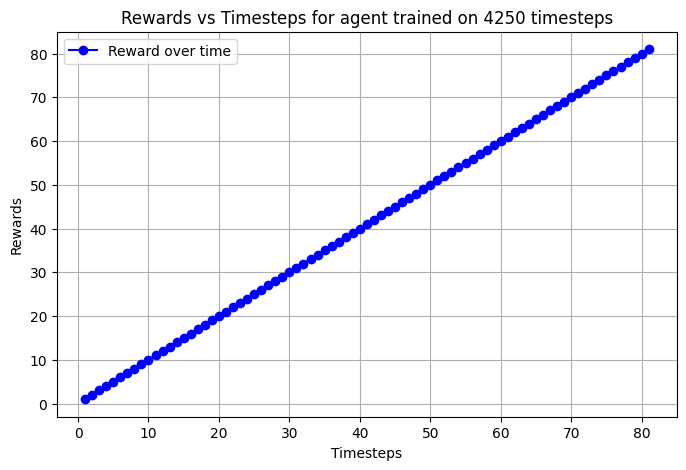

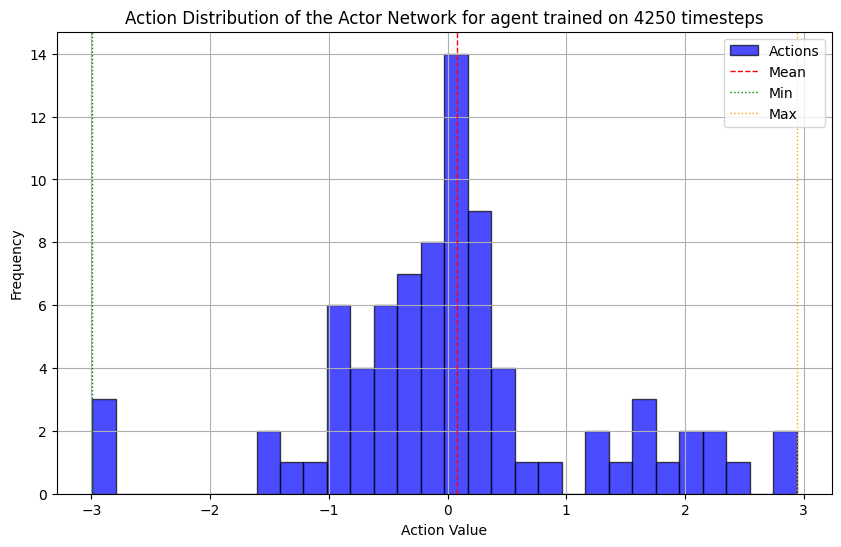

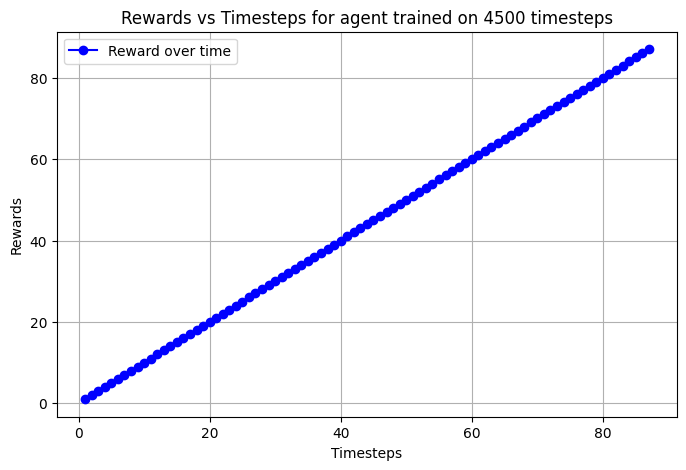

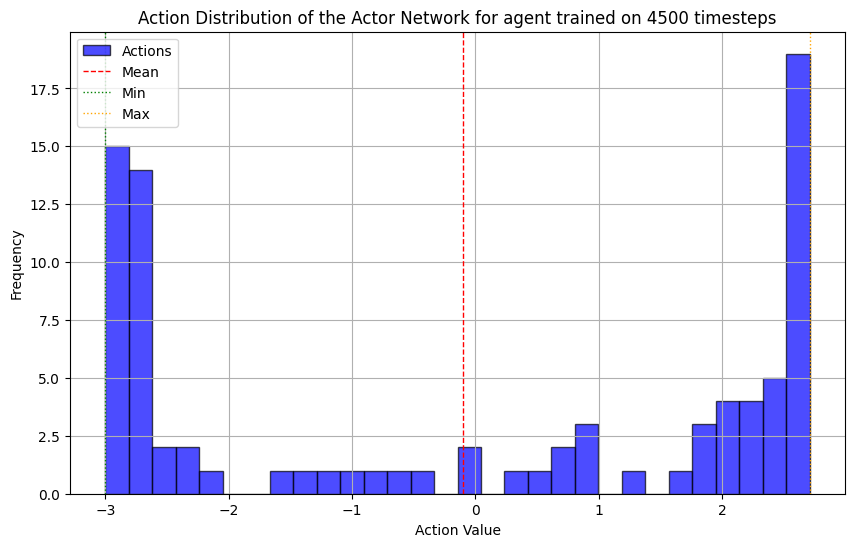

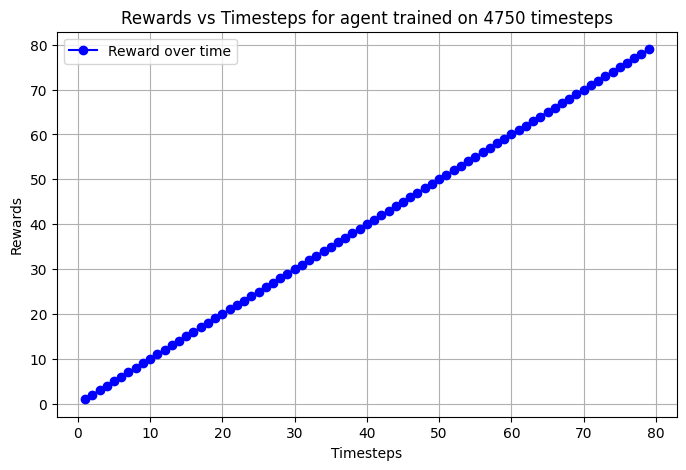

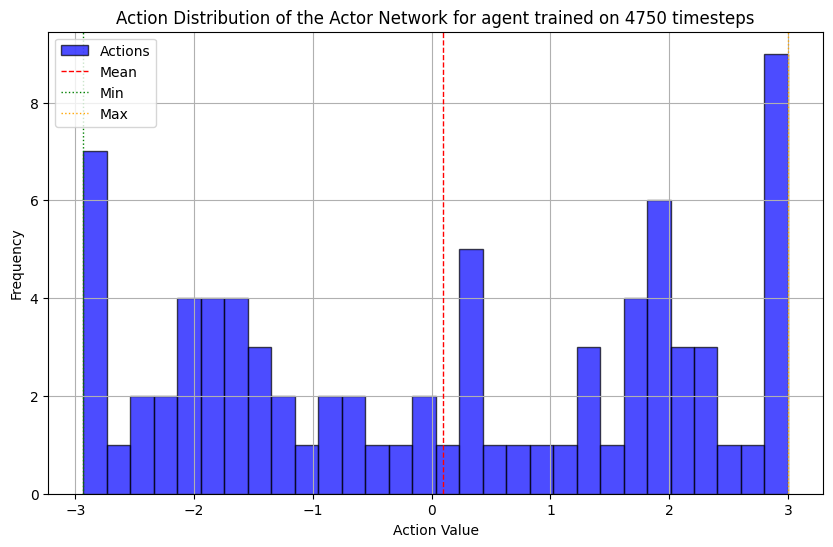

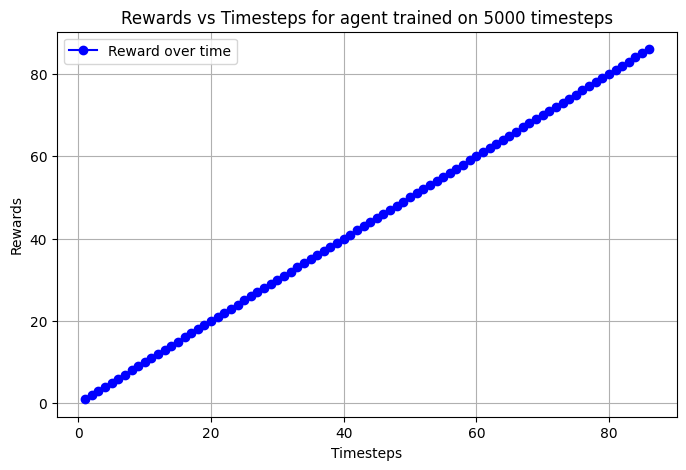

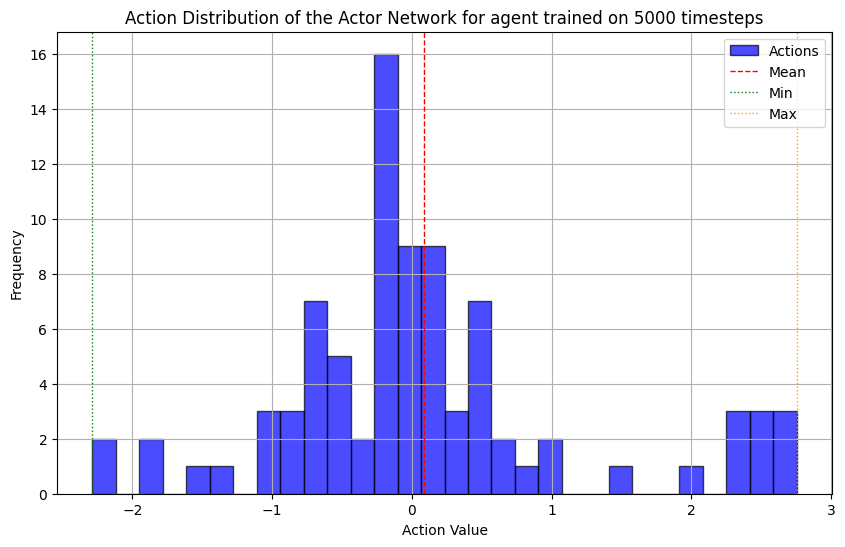

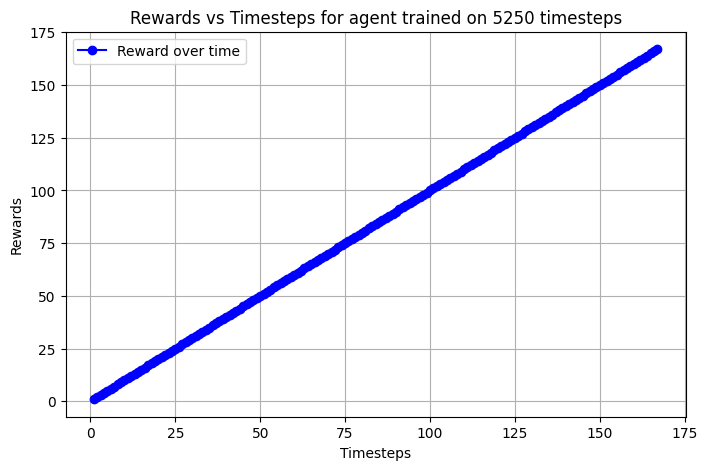

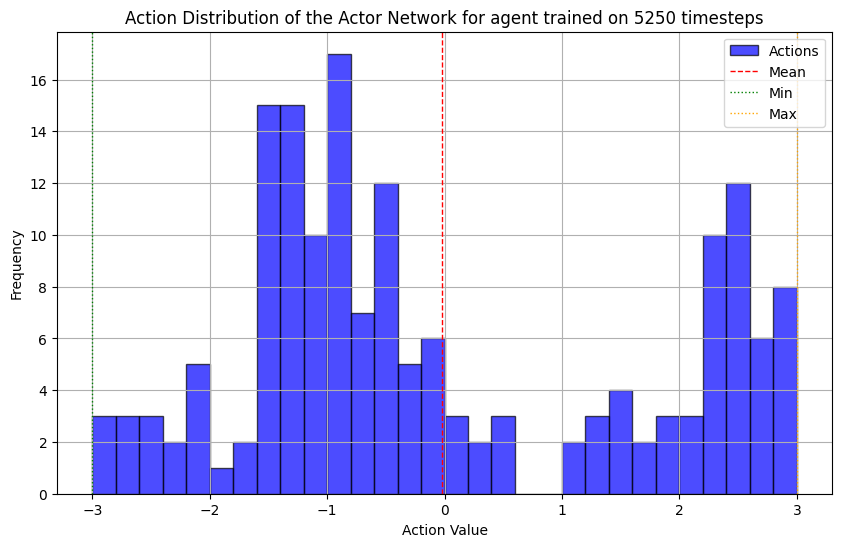

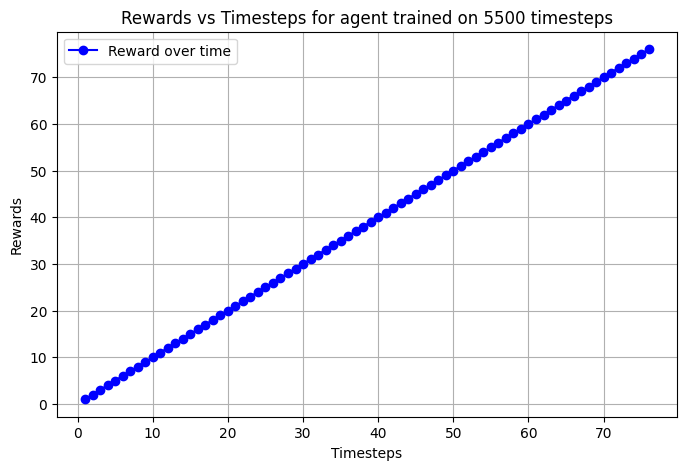

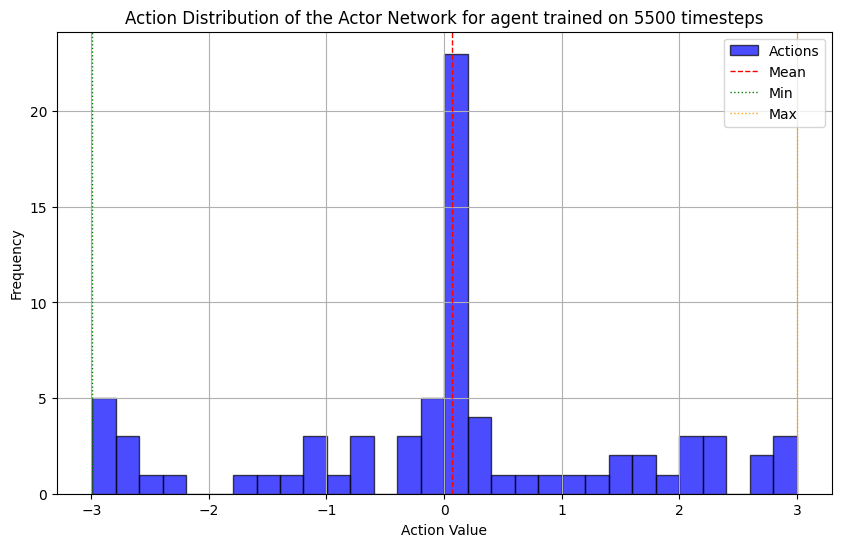

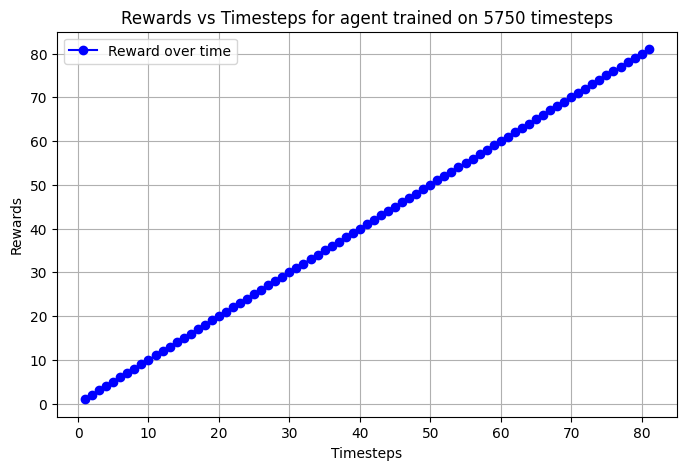

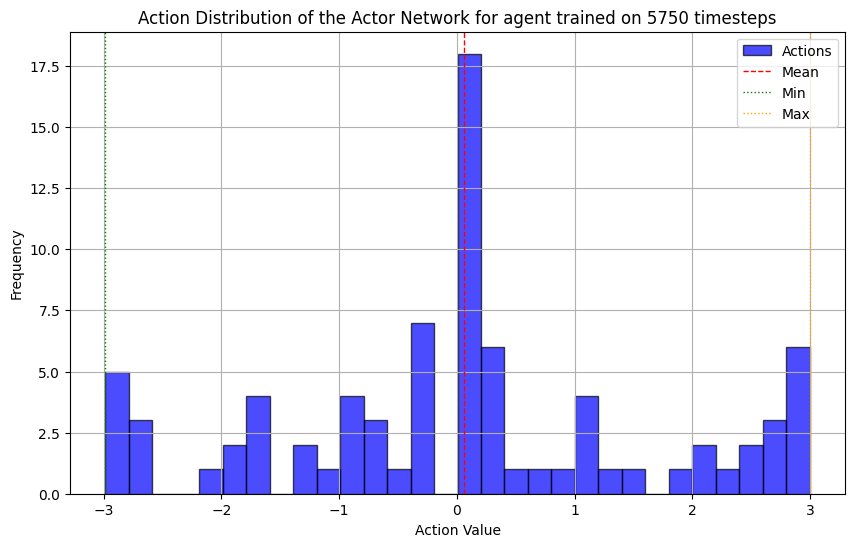

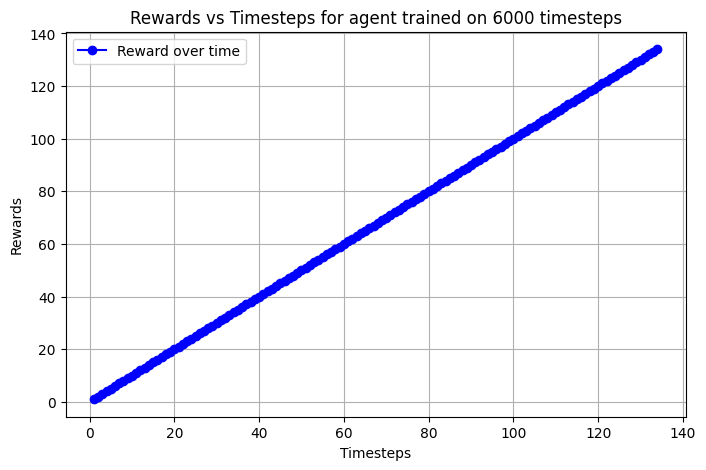

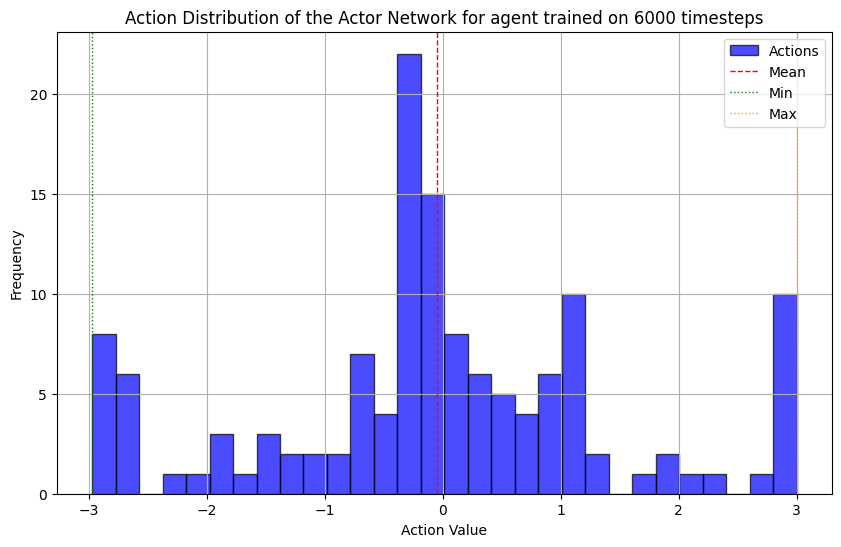

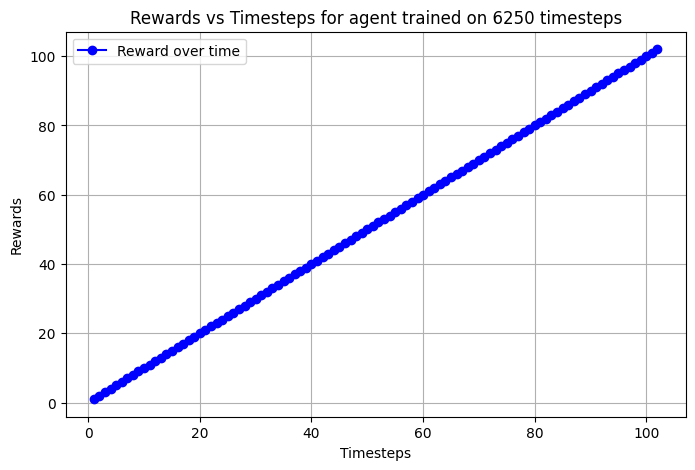

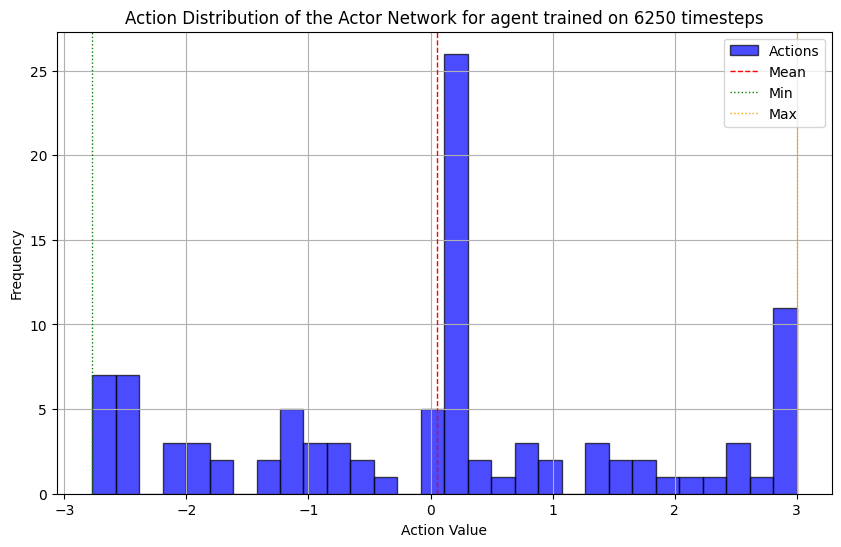

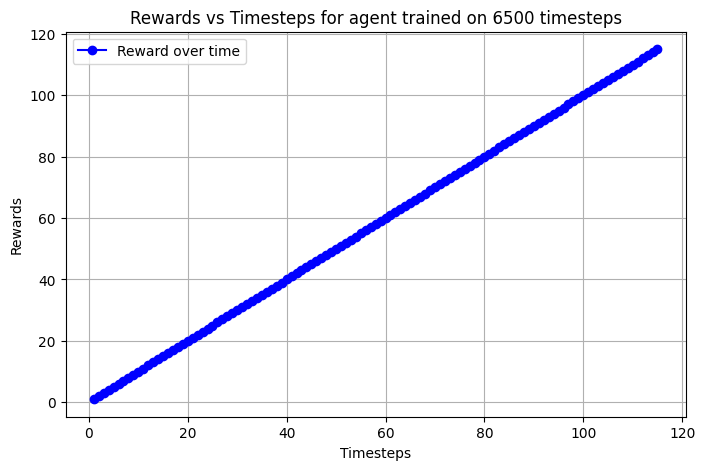

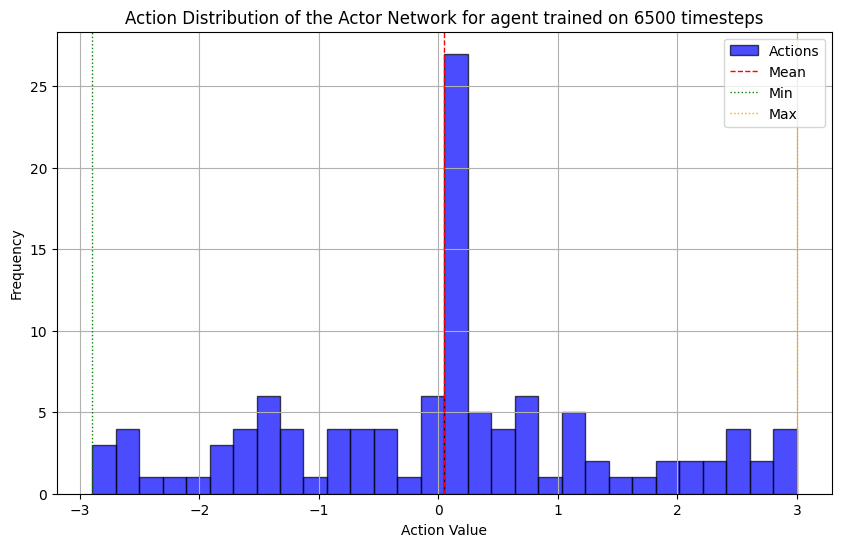

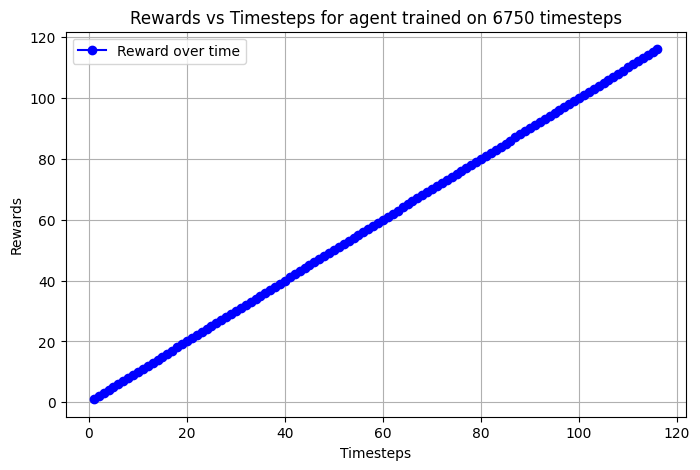

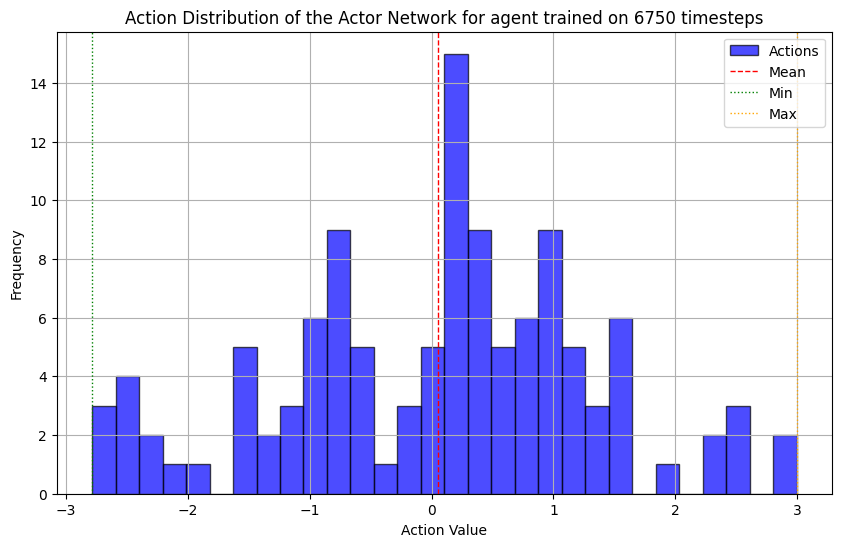

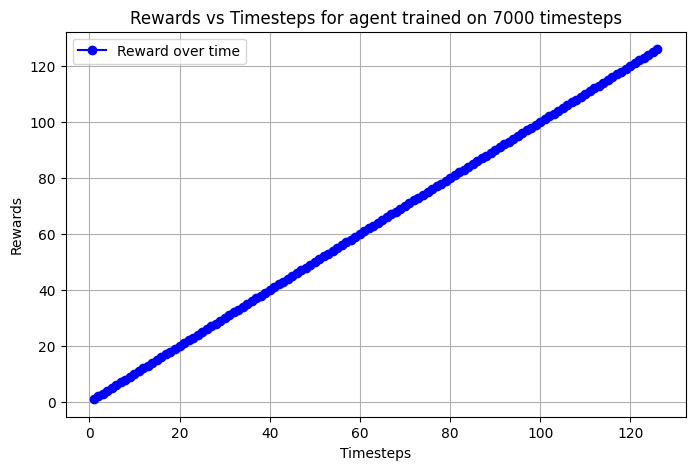

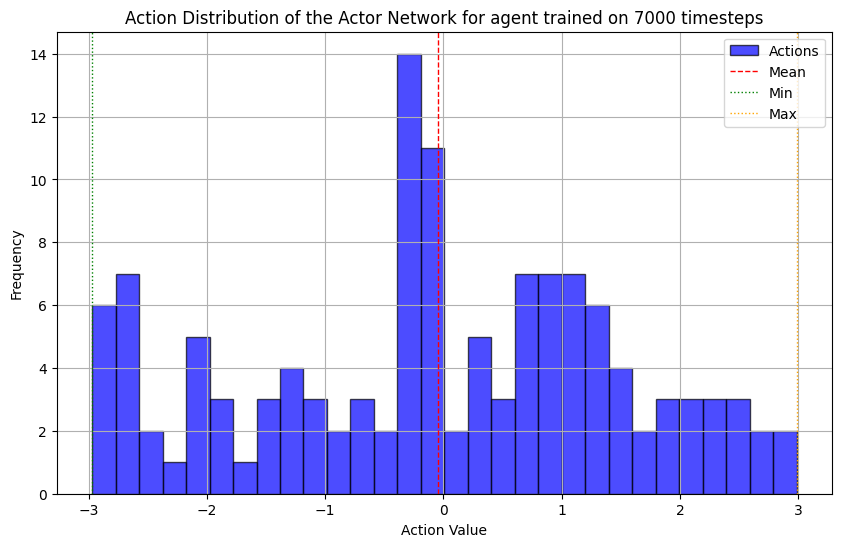

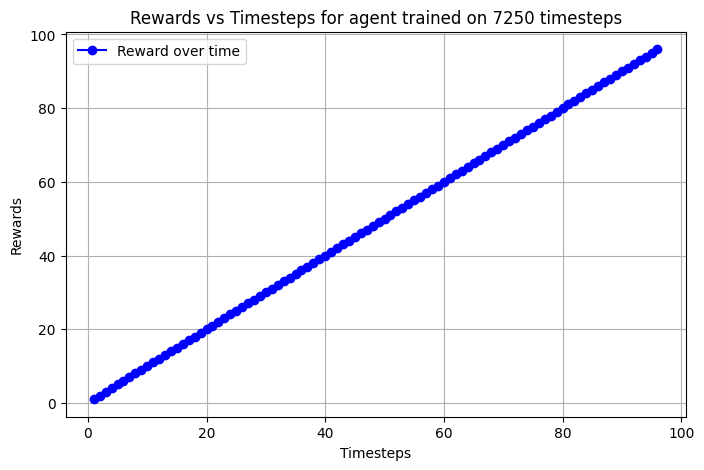

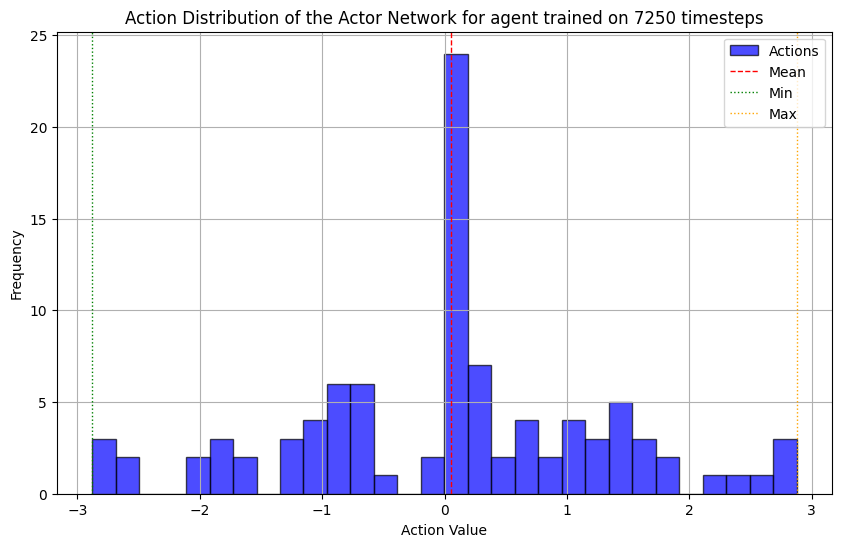

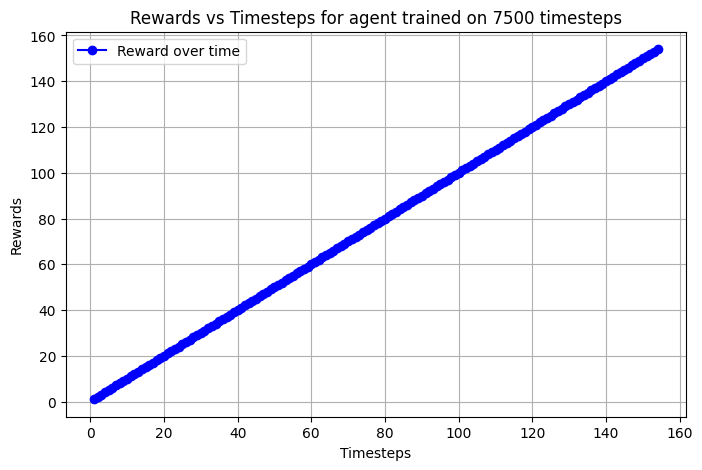

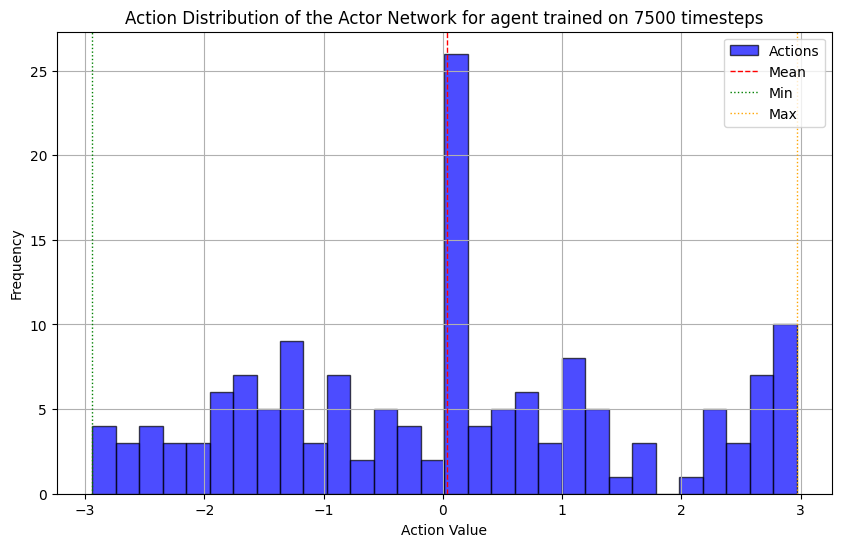

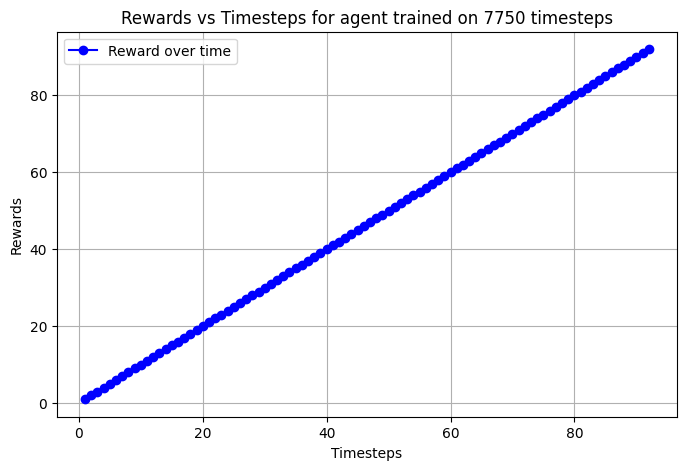

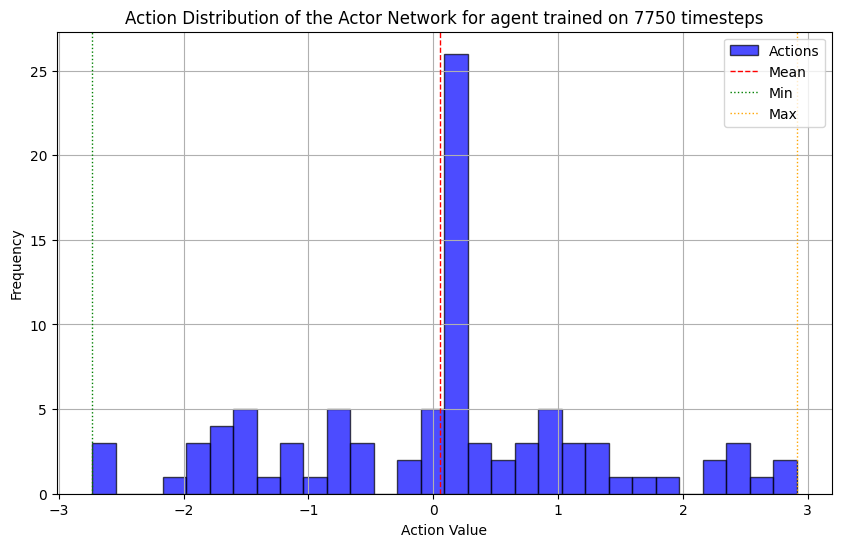

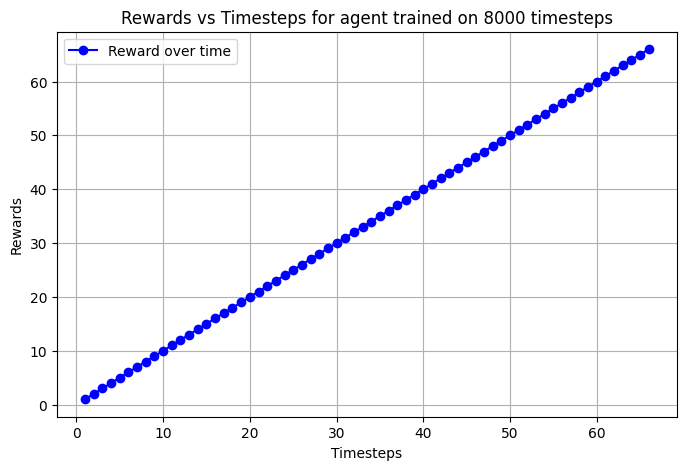

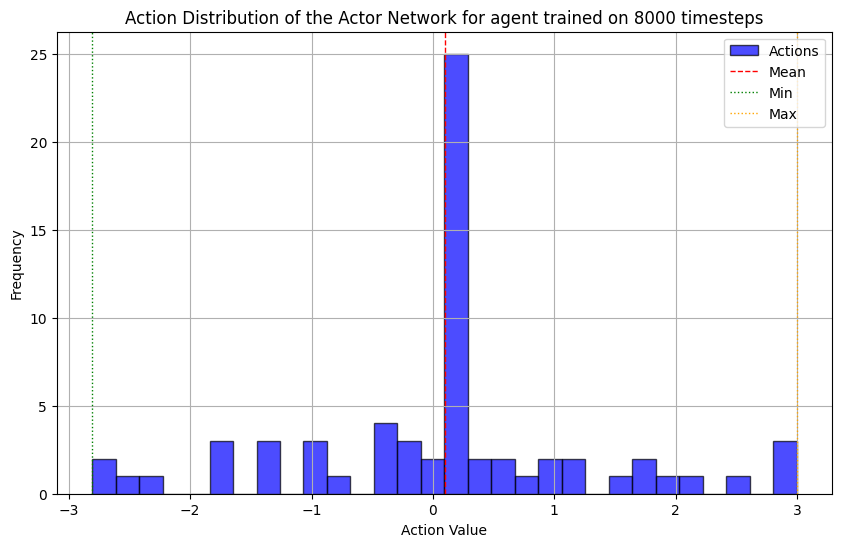

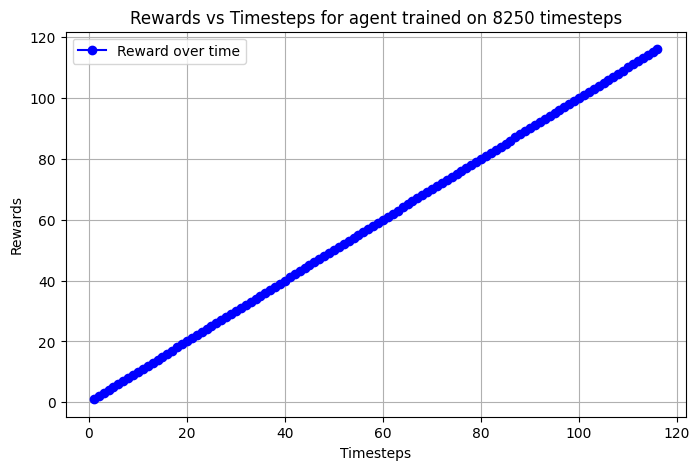

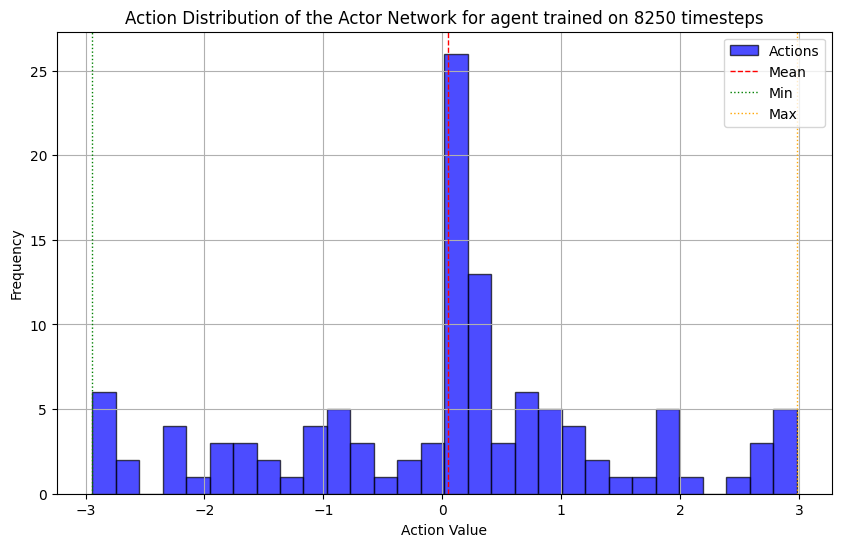

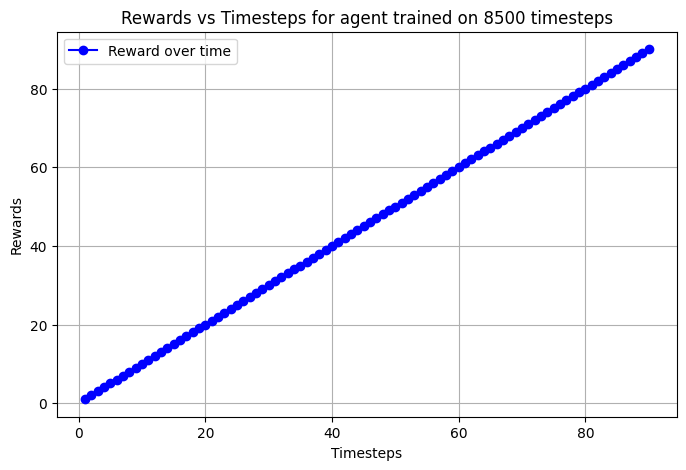

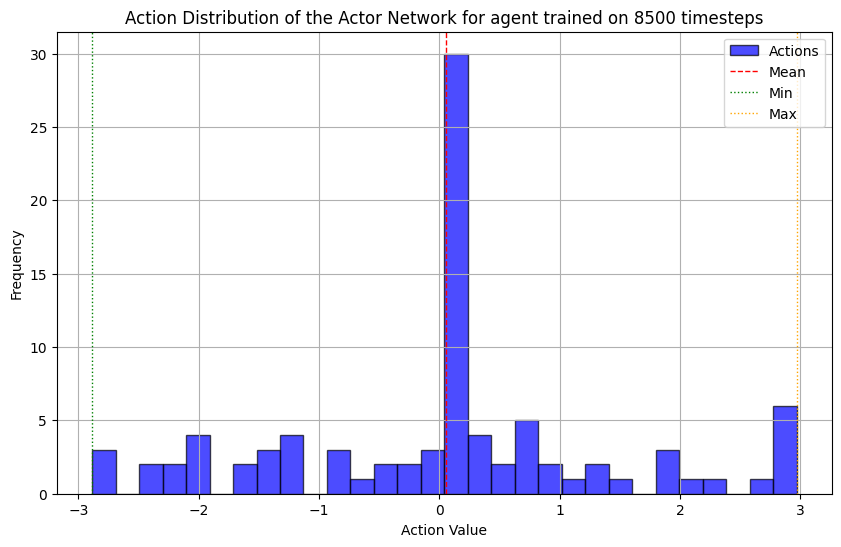

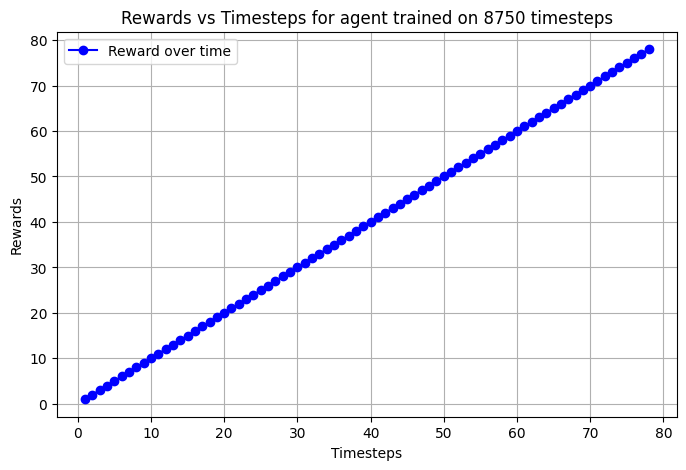

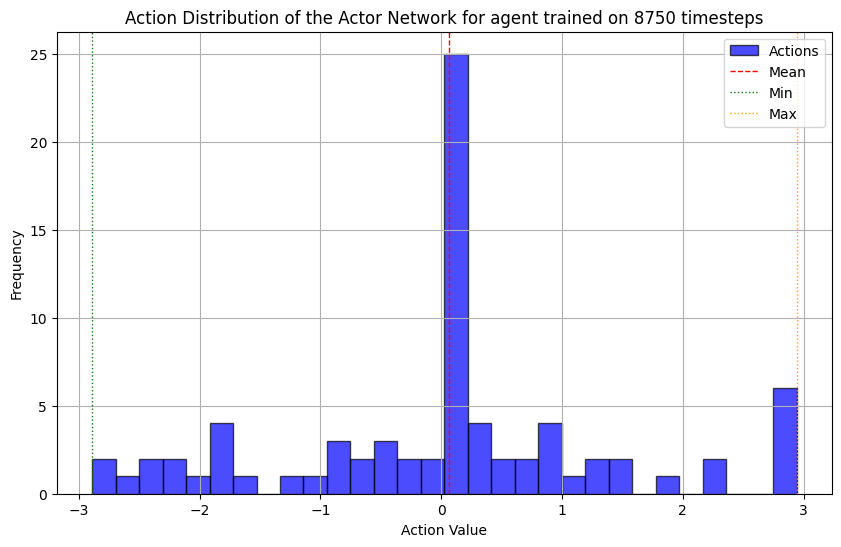

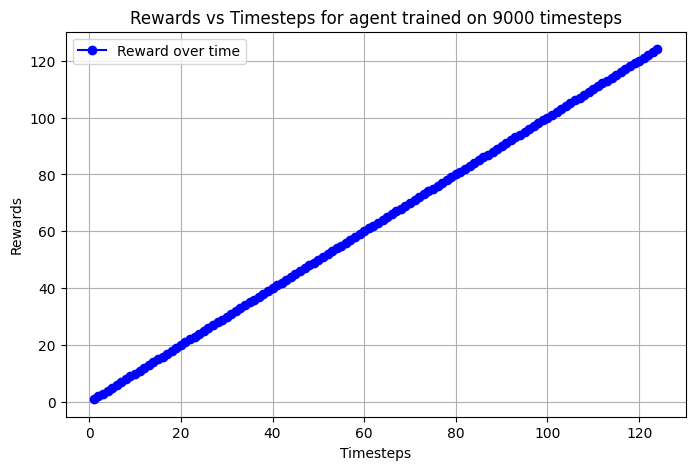

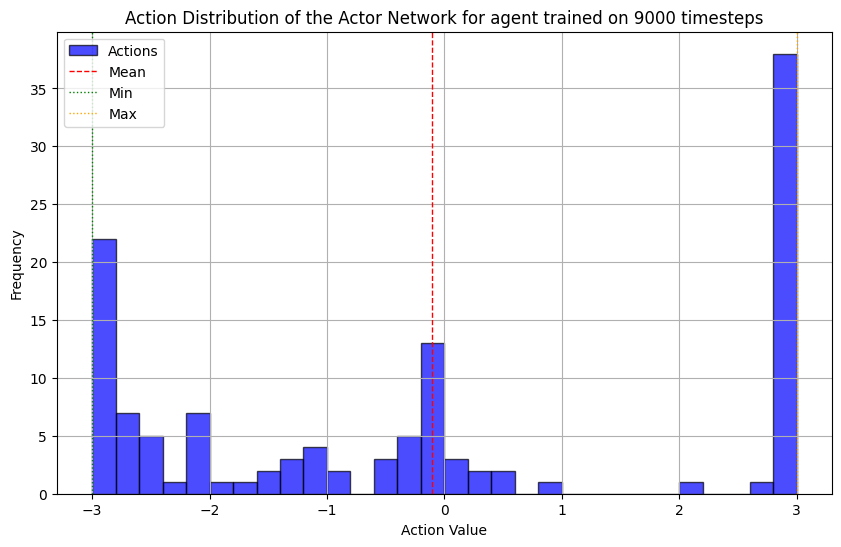

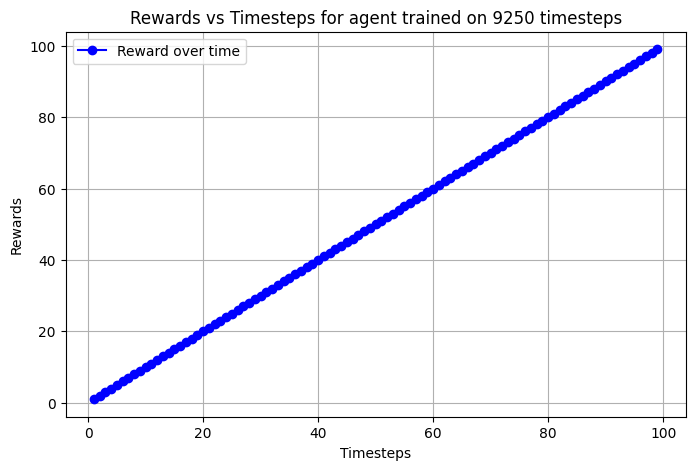

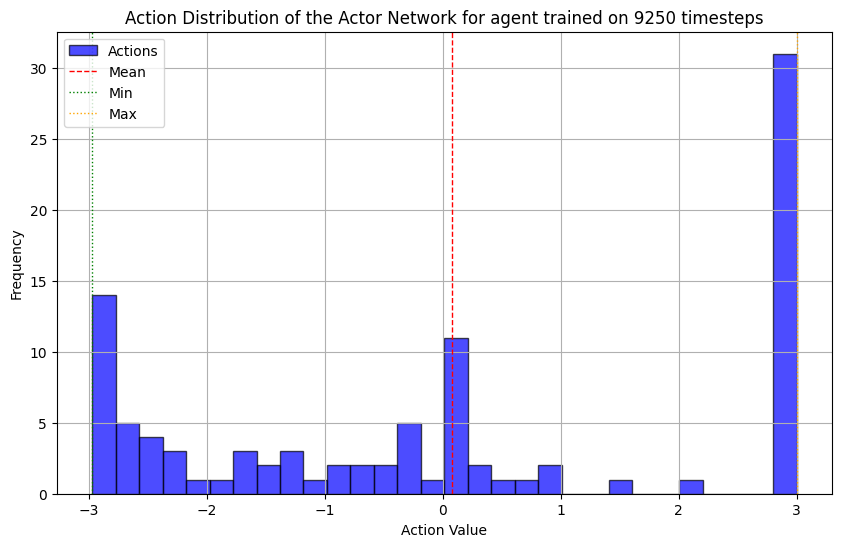

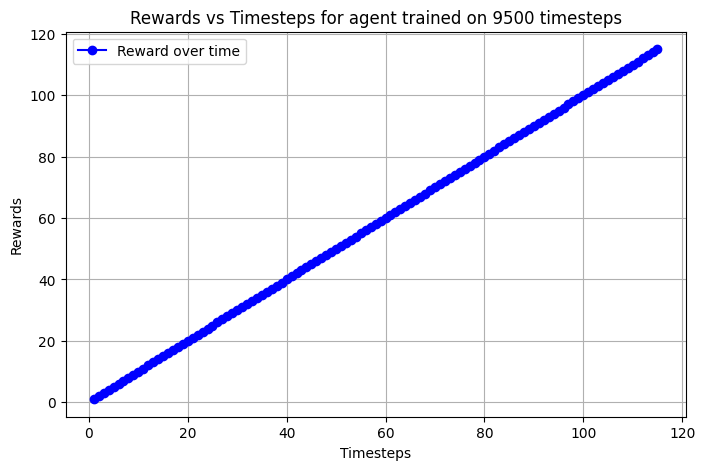

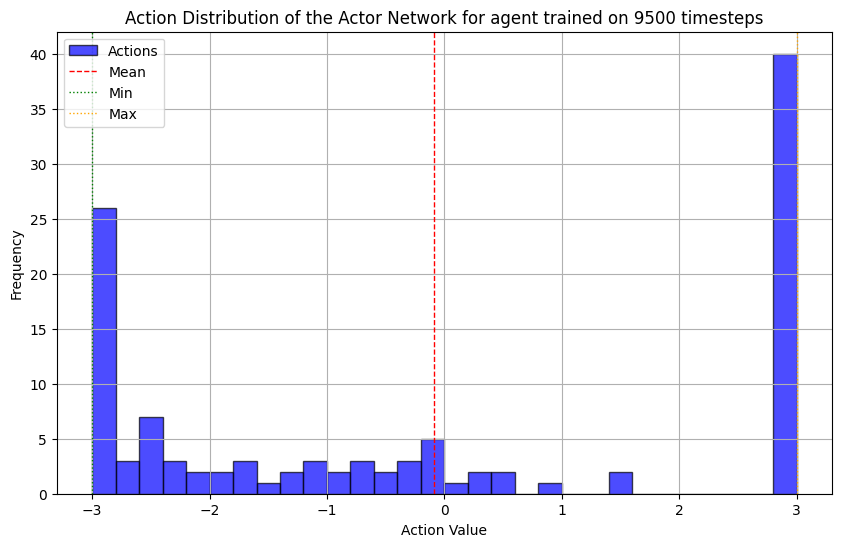

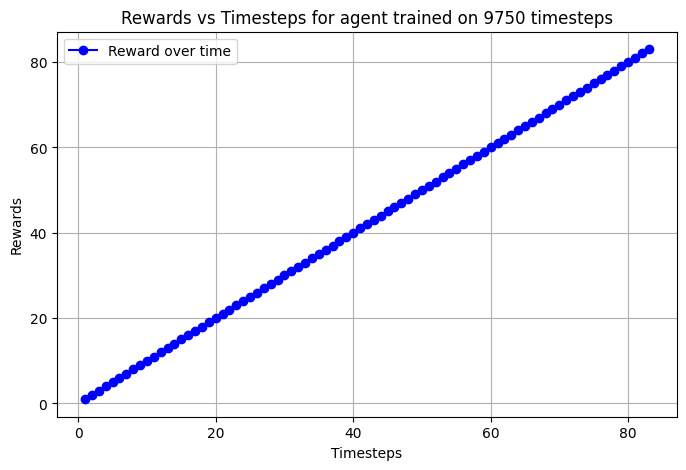

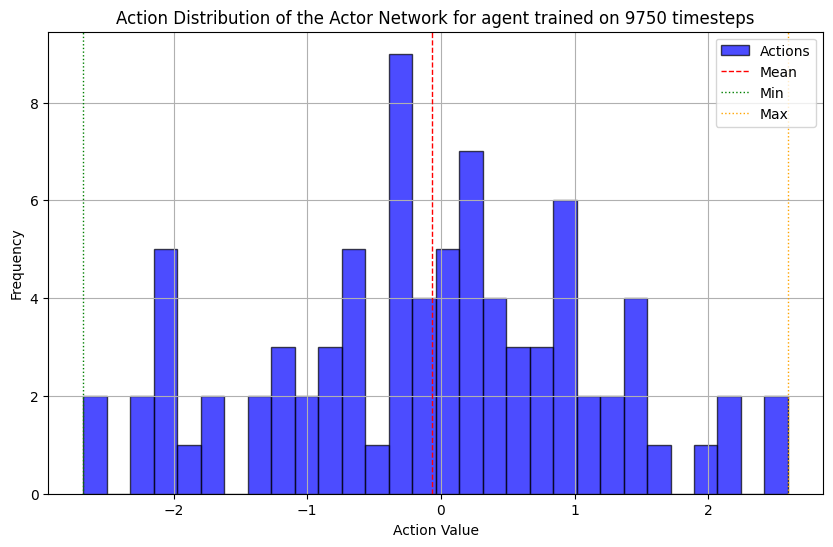

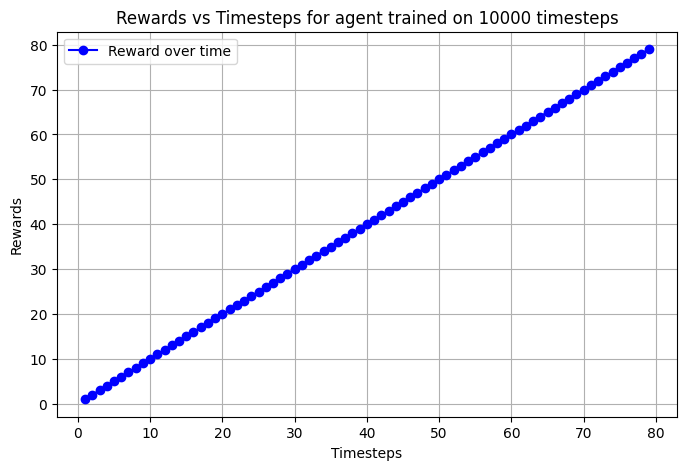

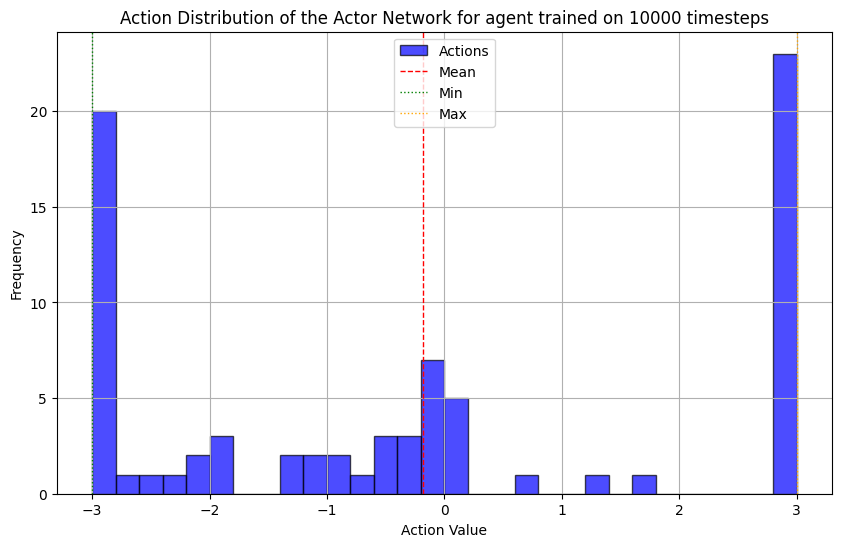

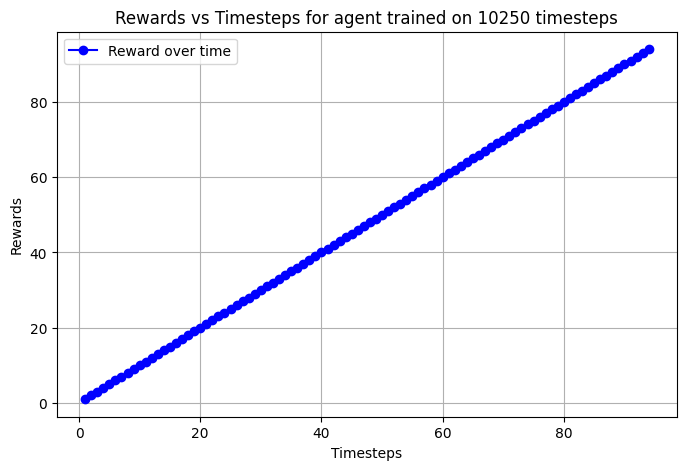

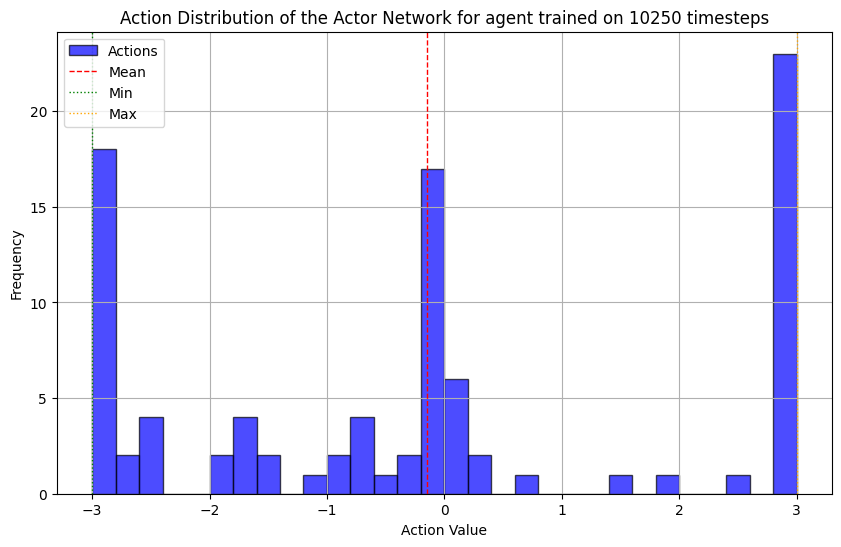

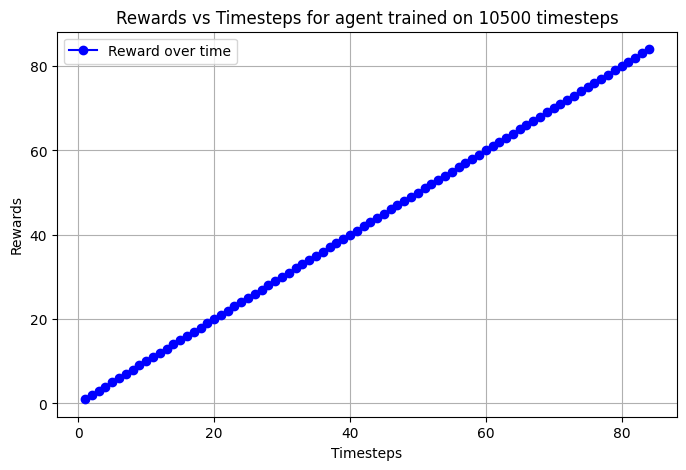

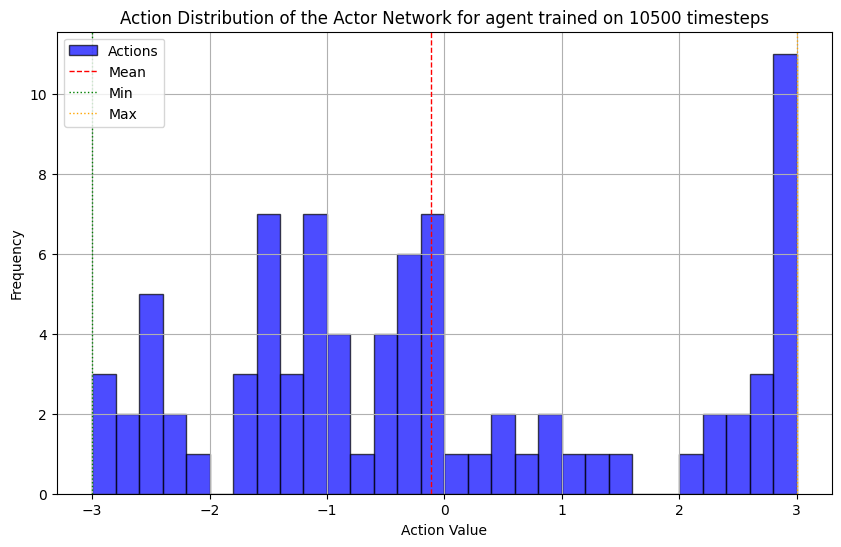

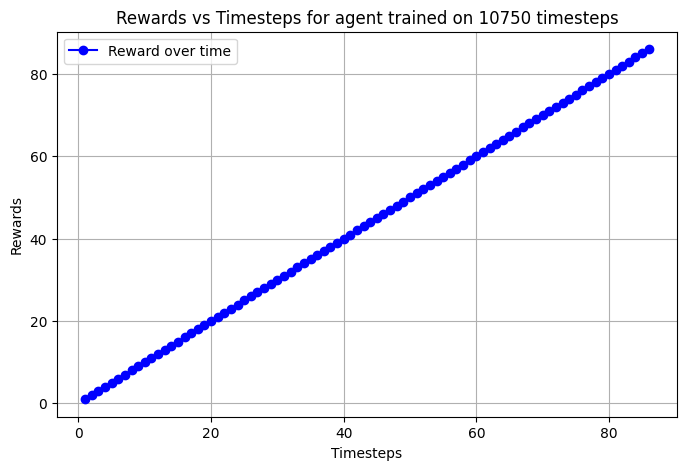

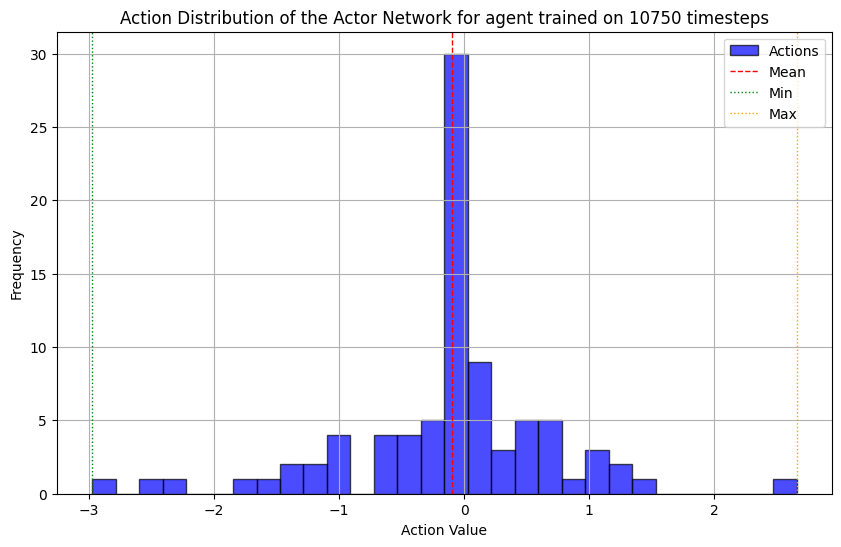

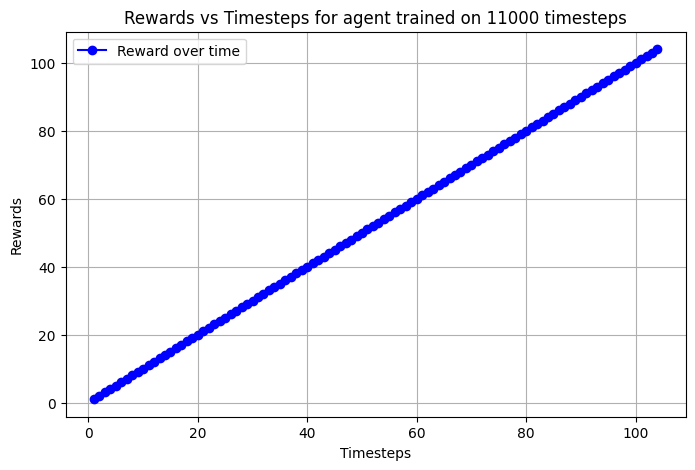

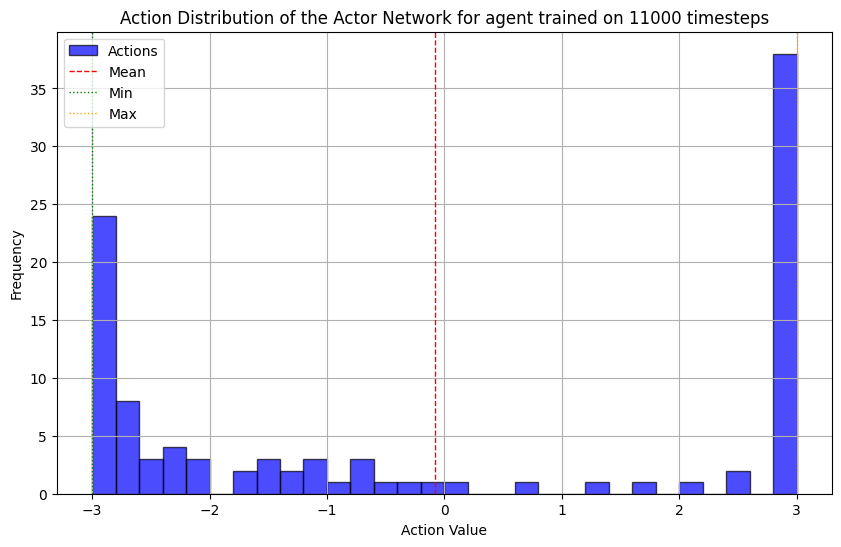

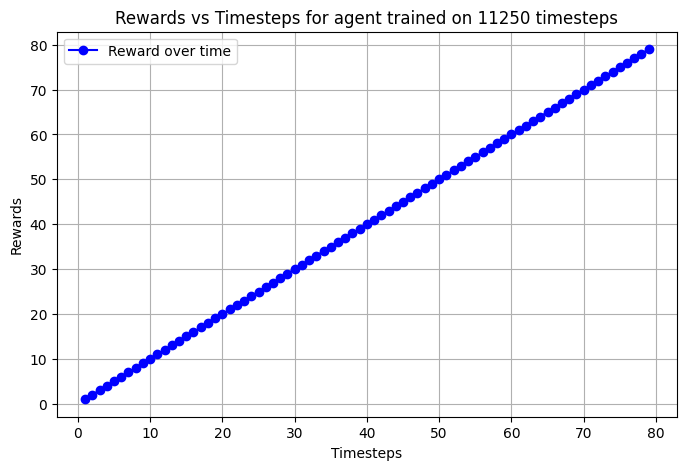

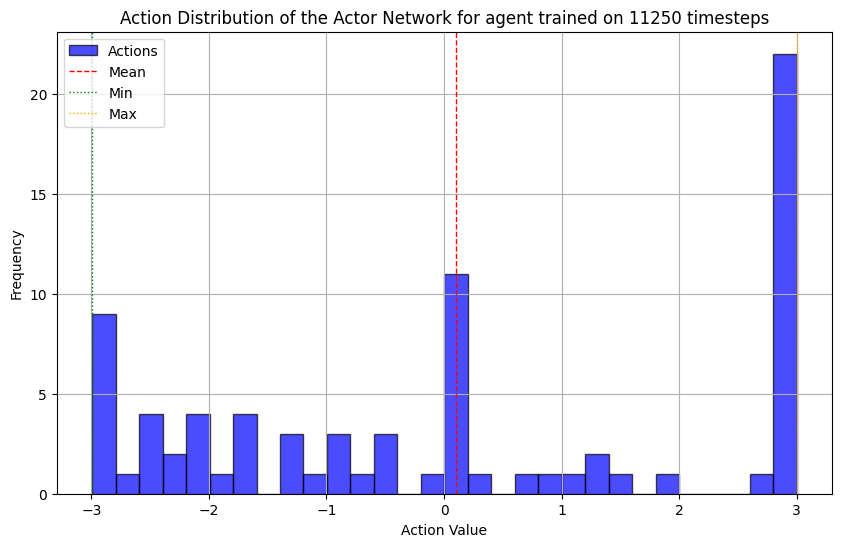

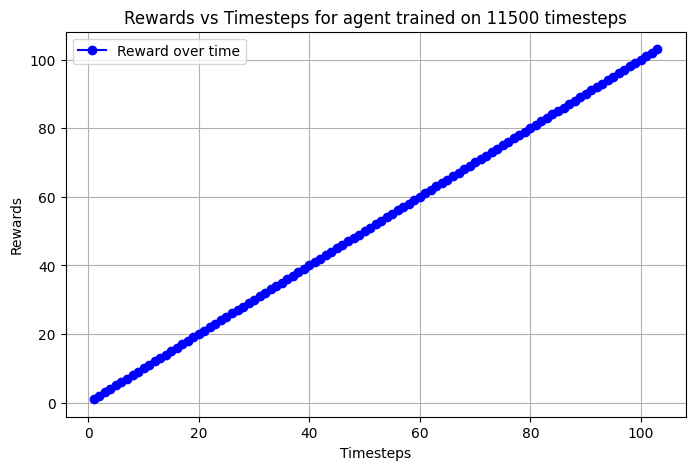

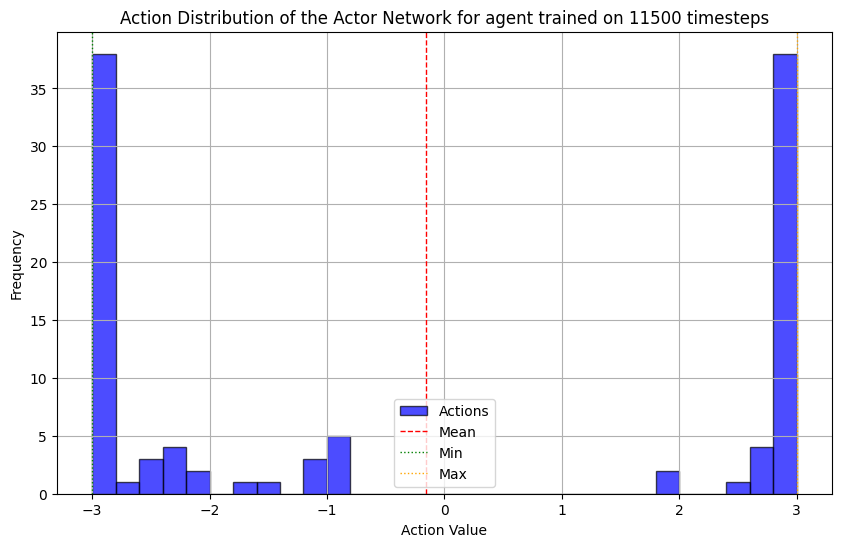

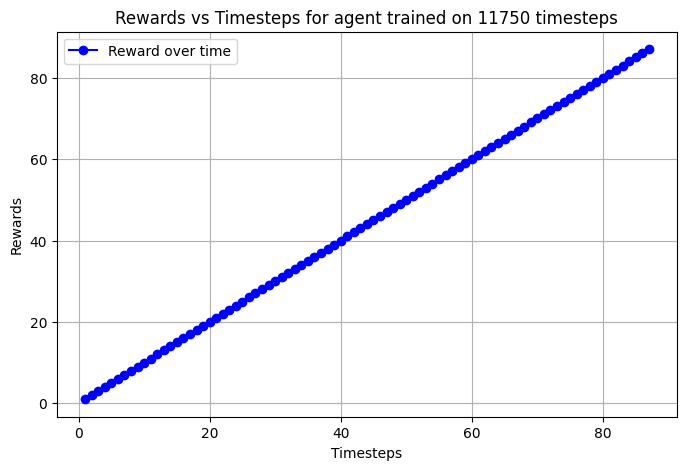

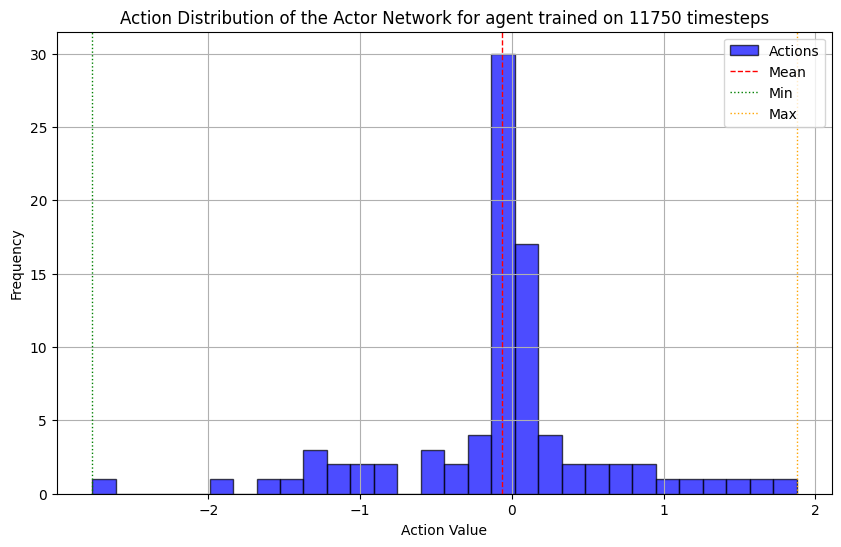

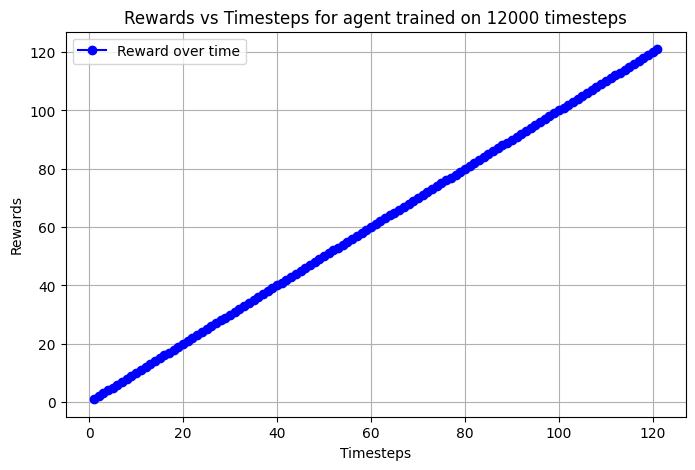

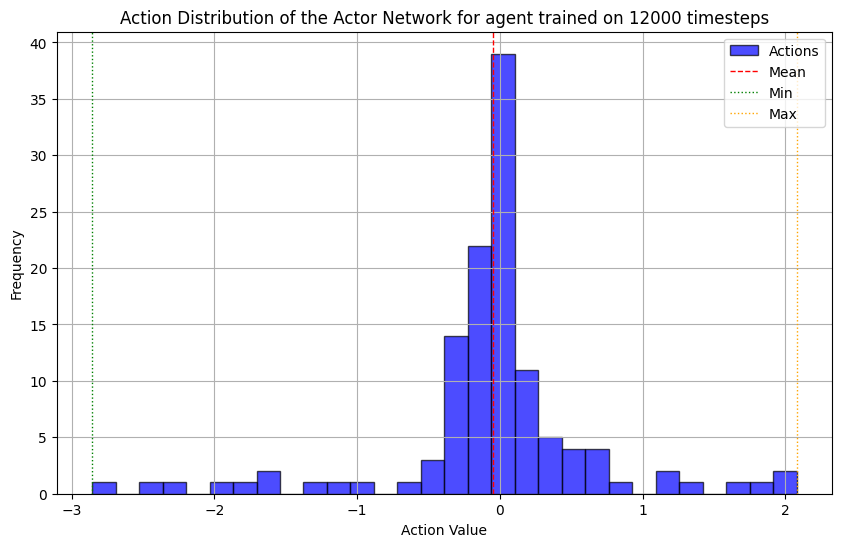

In [41]:
# Record videos for the highest-reward episodes for each training timestep
for y in models_saved:
    e = y
    timesteps = []
    reward_for_timestep = []
    rewards_count = 0
    if y in best_model_per_timestep and best_env_seed_per_timestep[y] is not None:
        env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")

        if y % video_save_freq == 0:
            print(f"Recording video for the best episode with {y} timesteps (reward: {highest_reward_per_timestep[y]})")
            folder_path = f"videos/best/timesteps_{training}/timesteps_{y}/"
            os.makedirs(folder_path, exist_ok=True)
            env = RecordVideo(env, video_folder=folder_path, name_prefix="eval_best_run",episode_trigger=lambda e:e % video_save_freq == 0)
        obs, info = env.reset(seed=best_env_seed_per_timestep[y])  # Reset with the saved seed
        
        done = False
        while not done:
            action, _ = best_model_per_timestep[y].predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            rewards_count+= reward
            reward_for_timestep.append(rewards_count)

        env.close()

        #create rewards graph for each timestep
        # Create the plot
        timesteps = list(range(1, len(reward_for_timestep) + 1))
        plt.figure(figsize=(8, 5))  # Optional: set figure size
        plt.plot(timesteps, reward_for_timestep, marker='o', linestyle='-', color='b', label='Reward over time')
        
        # Add labels and title
        plt.xlabel('Timesteps')
        plt.ylabel('Rewards')
        plt.title(f'Rewards vs Timesteps for agent trained on {y} timesteps')
       
        plt.legend()  # Add legend
        plt.grid(True)  # Optional: add grid
        rewards_path = f"videos/best/timesteps_{training}/Rewards vs Timesteps for agent trained on {y} timesteps"
        os.makedirs(f"videos/best/timesteps_{training}/", exist_ok=True)
        plt.savefig(rewards_path, dpi=300)
        # Display the plot
        #plt.show()

        #create Action Distribution Figure
        plt.figure(figsize=(10, 6))
        plt.hist(best_actions[y], bins=30, alpha=0.7, color="blue", edgecolor="black", label="Actions")
        plt.axvline(best_actions[y].mean(), color="red", linestyle="dashed", linewidth=1, label="Mean")
        plt.axvline(best_actions[y].min(), color="green", linestyle="dotted", linewidth=1, label="Min")
        plt.axvline(best_actions[y].max(), color="orange", linestyle="dotted", linewidth=1, label="Max")
        plt.xlabel("Action Value")
        plt.ylabel("Frequency")
        plt.title(f"Action Distribution of the Actor Network for agent trained on {y} timesteps")
        plt.legend()
        plt.grid(True)
        action_path = f"videos/best/timesteps_{training}/Action Distribution for agent trained on {y} timesteps"
        os.makedirs(f"videos/best/timesteps_{training}/", exist_ok=True)
        plt.savefig(action_path, dpi=300)
        #plt.show()

print(avg_rewards)
total_rewards = [sum(values) / len(values) for values in zip(*avg_rewards)]
total_std = np.std(avg_rewards, axis=0, ddof=1)

total_rewards = np.array(total_rewards,dtype=float)
total_std = np.array(total_std,dtype=float)
print(total_rewards)
print(total_std)
#print(best_actions)

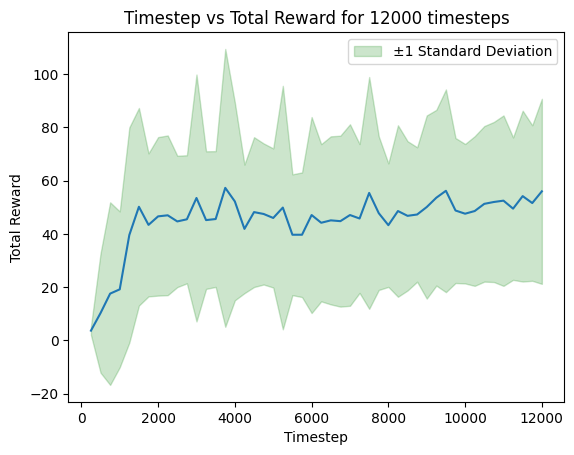

In [43]:
# Plot episode rewards
r = models_saved
plt.plot(r,total_rewards)
plt.fill_between(r,total_rewards - total_std, total_rewards + total_std,color='g', alpha=0.2, label='±1 Standard Deviation')
plt.xlabel("Timestep")
plt.legend()
plt.ylabel("Total Reward")
plt.title(f"Timestep vs Total Reward for {training} timesteps")
plt.savefig(f"videos/best/timesteps_{training}/Timestep vs Total Reward for {training}", dpi=300)
plt.show()